# Парсер вакансий Telegram

Выволнила: Соколова Александра (DA+, когорта 4)

## Задачи

1) Написать парсер вакансий с телеграмм-каналов;

2) Провести исследовательский анализ данных:
- определить основные критерии, по которым будем изучать количество вакансий (например, город, уровень зп, набор скиллов и тд)
- провести анализ текущей ситуации и сравнить с историческими данными (за квартал, 2 месяца, месяц, сейчас)
- составить портрет типичного аналитика данных уровня джун, джун+, миддл и тд
- сравнить с прошлыми портретами (информация будет предоставлена)
- дополнительные инсайты, которые найдете в данных.

3) собрать все результаты в хорошо-наглядный, читаемый дашборд или ноутбук с визуализациями

## Парсер вакансий в Telegram

Каналы:
- Data Science Jobs / AI / NN / ML / DL / NLP	
- Job for Analysts & Data Scientists
- Big Data Science job
- Business Intelligence HeadHunter
- Data jobs — вакансии по data science, анализу данных
- IT's Tinkoff jobs
- Data Analytics Jobs
- MegaFon Job
- Selectel Career
- MTS Bank IT&Digital Jobs

### Импорт библиотек

In [1]:
import pyrogram
import requests
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import os
from pyrogram import Client
import pandas as pd
import json
from datetime import datetime
import re
from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets

from pymystem3 import Mystem
from collections import Counter
from langdetect import detect
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from nltk.corpus import stopwords
import re


from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS

### Загрузка полученного файла

In [2]:
telegram = pd.read_csv(r'C:\Users\mirra\Desktop\Parser\telegram.csv')

In [3]:
telegram.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10663 entries, 0 to 10662
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   chat        6668 non-null   object
 1   message_id  10663 non-null  int64 
 2   date        10663 non-null  object
 3   text        9197 non-null   object
 4   entities    7293 non-null   object
dtypes: int64(1), object(4)
memory usage: 416.6+ KB


In [4]:
telegram.sort_values(by='date').head()

,chat,message_id,date,text,entities
980,"{\n ""_"": ""Chat"",\n ""id"": -1001137236002,...",1,2017-10-10 15:57:30,NaN,NaN
979,"{\n ""_"": ""Chat"",\n ""id"": -1001137236002,...",21,2018-03-12 16:12:12,NaN,NaN
978,"{\n ""_"": ""Chat"",\n ""id"": -1001137236002,...",46,2018-04-06 17:47:02,NaN,NaN
1908,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",1,2018-07-11 01:00:54,NaN,NaN
392,"{\n ""_"": ""Chat"",\n ""id"": -1001483488834,...",1,2018-12-24 03:33:21,NaN,NaN


## 1. Предобработка данных

### Задачи:

Провести предобработку и получить из данных:
- название чата и его ID;
- дату публикации вакансии (день недели, месяц, год);
- тип вакансии (ds, da, de);
- название должности каждого типа (в разрезе ds, da, de);
- уровень позиции (грейд);
- тип занятости;
- тип работы (в офисе или удаленно);
- условия работы;
- зарплату;
- город и страну.

In [5]:
# самая ранняя дата до удаления строк с пропусками
print('Cамой раннее сообщенте от', telegram['date'].min())
print('Последнее сообщение от ', telegram['date'].max())

Cамой раннее сообщенте от 2017-10-10 15:57:30
Последнее сообщение от  2022-06-12 10:31:21


In [6]:
telegram[telegram['date'].str.contains('2017-10-10')]

,chat,message_id,date,text,entities
980,"{\n ""_"": ""Chat"",\n ""id"": -1001137236002,...",1,2017-10-10 15:57:30,NaN,NaN


In [7]:
# удалим пропуски, сбросим индекс
telegram = telegram.dropna().reset_index(drop=True) 

# после удаления дубликатов сталась 5061 строка
telegram.shape

(5277, 5)

In [8]:
# по строкам полных дубликатов нет
telegram.duplicated().any()

False

In [9]:
# по колонке text есть 759 дублей
# они возникают, т.к. вакансии выкладывали несколько раз в разное время или в разных каналах
telegram[telegram['text'].duplicated()]

,chat,message_id,date,text,entities
329,"{\n ""_"": ""Chat"",\n ""id"": -1001483488834,...",18,2019-03-23 18:05:49,▪️Data Scientist - Machine Learning в Москве\n...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
461,"{\n ""_"": ""Chat"",\n ""id"": -1001137236002,...",4317,2022-04-27 15:12:08,Data Analyst\nв Lesta Studio — российская комп...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
509,"{\n ""_"": ""Chat"",\n ""id"": -1001137236002,...",4265,2022-04-12 13:10:08,Senior Product Analyst\nв Звук — мультиплатфор...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
523,"{\n ""_"": ""Chat"",\n ""id"": -1001137236002,...",4250,2022-04-07 17:05:12,Senior Product Analyst\nв Global Payments — ам...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
552,"{\n ""_"": ""Chat"",\n ""id"": -1001137236002,...",4220,2022-03-31 16:02:07,Продуктовый аналитик\nв Ингосстрах-Инвестиции ...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
...,...,...,...,...,...
4978,"{\n ""_"": ""Chat"",\n ""id"": -1001165814759,...",381,2021-03-21 16:01:00,Разработчик в команду распределенного запуска ...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
4983,"{\n ""_"": ""Chat"",\n ""id"": -1001165814759,...",375,2021-03-18 16:01:00,ML-разработчик в Маркет ♟\n\nЯндекс.Маркет акт...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
5097,"{\n ""_"": ""Chat"",\n ""id"": -1001269722631,...",140,2021-10-18 19:00:21,Frontend-разработчик (Angular) ⌨️\nВ Тинькофф ...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
5111,"{\n ""_"": ""Chat"",\n ""id"": -1001269722631,...",125,2021-09-22 19:30:15,Разработчик Full-Stack .NET ⚙️\nМы разрабатыва...,"[\n {\n ""_"": ""MessageEntity"",\n ..."


In [10]:
# удалим дубликаты по столбцу text
telegram = telegram.drop_duplicates(subset=['text'], keep='last')
telegram.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4518 entries, 0 to 5276
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   chat        4518 non-null   object
 1   message_id  4518 non-null   int64 
 2   date        4518 non-null   object
 3   text        4518 non-null   object
 4   entities    4518 non-null   object
dtypes: int64(1), object(4)
memory usage: 211.8+ KB


### Парсим ссылки внутри сообщений о вакансиях

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Большая часть ссылок устарела, информации по вакансии там, к сожалению, не содержится. 
Но по ссылкам сайта proglib данные есть, их ниже и спарсим. 

</div>

In [11]:
def get_links(x, regexp='http\S+'): ###
    try:
        for i in json.loads(x['entities']):
            if i['type'] == 'MessageEntityType.TEXT_LINK':
                return i['url']
            elif i['type'] == 'MessageEntityType.URL':
                url = re.findall(regexp, x['text'])[0]
                return url
    except:
        return None
        
telegram['url'] = telegram.apply(get_links, axis=1)
#telegram['url']

In [12]:
proglib = r'proglib'
telegram['url'] = telegram['url'].astype('str')
telegram['proglib'] =  telegram['url'].apply(lambda x: True if re.search(proglib, x) else False).astype('str')

In [13]:
### Парсим ссылки

def parse_site(url, element='div', extra_info=None):
    try:
        data = requests.get(url).text ###
        soup = BeautifulSoup(data)
        elements = []
        for extra in extra_info:
            elements += soup.find_all(element, extra)
        html = ''
        for i in elements:
            html += str(i)
        return html
    except Exception as e:
        return '<p>Не удалось получить элемент</p>'
    
### классы на рассматриваемых сайтах

extra_infos = [{'class': 'list-parent vacancy-desc'}, 
               {'class': 'bp-Vacancy__description bp-VacancyDescription'}, 
               {'id': 'vacancy-description'},
               {'class': 'section__block panel js-show'}]


#telegram['parsed_text'] = telegram.query('proglib == "True"')['url'].apply(lambda x: parse_site(x, extra_info=extra_infos))  
#telegram.loc[1]['parsed_text']

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> Так как парсинг ссылок занимает много времени, получившийся файл я сохраню в отдельный датафрейм и повторно загружу его в тетрадку для дальнейшей работы. 

</div>

In [14]:
telegram.shape

(4518, 7)

In [15]:
# проверяем, что все спарсилось и объединилось корректно
#telegram.loc[1]['parsed_text']
#telegram.loc[1]['text']
#telegram['text'] = telegram['text'] + telegram['parsed_text'] 
#telegram.loc[1]['text']

In [16]:
telegram_parsed = telegram.to_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Пасека\telegram_parsed.csv')

In [17]:
telegram = pd.read_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Пасека\telegram_parsed.csv')
telegram = telegram.drop(['url', 'proglib'], axis=1)

In [18]:
telegram.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4518 entries, 0 to 4517
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4518 non-null   int64 
 1   chat        4518 non-null   object
 2   message_id  4518 non-null   int64 
 3   date        4518 non-null   object
 4   text        4518 non-null   object
 5   entities    4518 non-null   object
dtypes: int64(2), object(4)
memory usage: 211.9+ KB


### Добавим из столбца чат ID и название чата

In [19]:
telegram["chat_id"] = telegram["chat"].apply(lambda x: json.loads(x)['id'])
telegram["title"] = telegram["chat"].apply(lambda x: json.loads(x)['title'])

# доля сообщений в каждом канале 
chats_share = (
    telegram.groupby(['chat_id', 'title'])['chat_id']
    .count()
    .to_frame()
    .rename(columns={'chat_id':'count'})
    .reset_index()
    .sort_values(by='count', ascending=False)
    .reset_index()
)    

chats_share['share'] = chats_share['count'] / chats_share['count'].sum()
chats_share

,index,chat_id,title,count,share
0,6,-1001269377842,Data jobs feed,843,0.186587
1,8,-1001165814759,Яндекс нанимает,820,0.181496
2,11,-1001137236002,Job for Analysts & Data Scientists,555,0.122842
3,2,-1001321264581,Data Science Jobs / AI / NN / ML / DL / NLP,545,0.120629
4,9,-1001164864072,Big Data Science job,456,0.100930
5,3,-1001291755040,Business Intelligence HeadHunter,415,0.091855
6,0,-1001483488834,"Data jobs — вакансии по data science, анализу ...",320,0.070828
7,5,-1001269722631,IT's Tinkoff jobs,238,0.052678
8,7,-1001269328727,Data Analytics Jobs,190,0.042054
9,10,-1001159595548,MegaFon Jobs,64,0.014166


### Pre-cleaning колонки text

In [20]:
telegram['text'] = telegram['text'].str.lower().str.strip()
telegram['text'] = telegram['text'].str.replace('\xa0', ' ')

In [21]:
# исключим вакансии, которые не рассматриваем в данном проекте

not_needed_vac= r'дизайнер|тестировщик|преподаватель|тестированию|проектировщик|фронтенд|frontend|техподдерж|ios|бэкенд|fullstack|golang|Node|NodeJS|Haskell'
telegram['not_needed_vac'] = telegram['text'].apply(lambda x: True if re.search(not_needed_vac, x.lower()) else False)
telegram = telegram.query('not_needed_vac != True')
telegram = telegram.drop('not_needed_vac', axis=1)

telegram.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3749 entries, 0 to 4517
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3749 non-null   int64 
 1   chat        3749 non-null   object
 2   message_id  3749 non-null   int64 
 3   date        3749 non-null   object
 4   text        3749 non-null   object
 5   entities    3749 non-null   object
 6   chat_id     3749 non-null   int64 
 7   title       3749 non-null   object
dtypes: int64(3), object(5)
memory usage: 263.6+ KB


### Определение типа вакансии (DE, DA, DS) 

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> 
Т.к. регулярные выражения ищут все совпадения по тексту, тип вакансии определяется не совсем точно, много пересечений (например, вакансия может быть причислена и к ds и к da). 
        Чтобы минимизировать неточности, выделю два дополнительных столбца (vac_name, vac_name_2), куда вынесен блок текста до первой табуляции и до первой запятой. Это поможет повысить точность определения, т.к. обычно название должности указано вначале описания.
</div>

In [22]:
# разделяем колонку text на блоки по запятой и знаку табуляции.
# оставляем первую строчку (там, как правило, содержится название должности)

telegram = telegram.assign(vac_name = lambda x: x['text'].apply(lambda x: x.split(sep=',')[0]))

telegram = telegram.assign(vac_name_2 = lambda x: x['text'].apply(lambda x: x.split(sep='\n')[0]))
'xxxx <strong> yyyyy <strong> zzzzz'. split(sep='\n')[0]

def reg_words(row):
    vac_name = row['vac_name']
    vac_name = re.sub("[^A-Za-zА-Яа-я]", " ", vac_name).replace('  ', ' ')
    return vac_name

telegram['vac_name'] = telegram.apply(reg_words, axis=1)  

###

def reg_words_2(row):
    vac_name_2 = row['vac_name_2']
    vac_name_2 = re.sub("[^A-Za-zА-Яа-я]", " ", vac_name_2).replace('  ', ' ')
    return vac_name_2
telegram['vac_name_2'] = telegram.apply(reg_words_2, axis=1)

#telegram.tail(40)
#telegram.loc[640:700].head(40)
#telegram.head()

In [23]:
# определим регулярные выражения для определения нужного типа вакансии (DE, DA, DS) 

ds = (r'(разработчик.*?bigdata)|(разработчик.*?big)|(специалист.*?bigdata)|(специалист.*?big.*?data)|quantitative|(quantitative.*?developer)|(ml.*?developer)|(head.*?of.*?ml)|(разработчик.*?машинного.*?обучения)|(специалист.*?компьютерному.*?зрению)|(специалист.*?по.*?ml)|датасаентистов|(ml.*?разработчик)|(data.*?scientist)|(data.*?science)|datascientist|datascience|сайентиста|сайентисты|(learning.*?engineer)|(machine.*?learning)|(computer.*?vision)|(data.*?mining)|(рукописного.*?текста)|(ml.*?инженер)|(ml.*?engineer)|(разработчик.*?ml)|(machine.*?learning.*?инженер)|(machine.*?learning.*?engineer)|(инженер.*?машинного.*?обучения)|(bigdata.*?инженер)|(big.*?data.*?инженер)|(bigdata.*?engineer)|(big.*?data.*?engineer)|(bigdata.*?developer)|(big.*?data.*?engineer)|(big.*?data.*?developer)|bigdataengineer|(nlp.*?инженер)|(nlp.*?engineer)|(инженер.*?nlp)|(сomputer.*?vision.*?инженер)|(сomputer.*?vision.*?engineer)|(cv.*?engineer)|(cv.*?инженер)|(computervision.*?developer)|сomputer_vision|#computervision|cvengineer|(дата.*?саентиста)|(дата.*?саентист)'
     )
da = (r'(data.*?officer)|analyst|аналитик|(ведущий.*?аналитик)|(начинающий.*?аналитик)|(младший.*?аналитик)|(маркетолог.*?аналитик)|(investigation.*?analyst)|(data.*?analyst)|(data.*?аналитик)|(аналитик.*?данных)|датааналитик|(аналитиков.*?данных)|dataanalyst|dataanalyst|analytics|(продуктовый.*?аналитик)|(product.*?analyst)|(product.*?аналитик)|(аналитика.*?продукта)|product|(marketing.*?аналитик)|(marketing.*?analyst)|(маркетинг.*?analyst)|маркетинговый|маркетинговой|маркетингового|маркетинга|(бизнес.*?аналитик)|(business.*?analyst)|business_analyst|#businessanalyst|(веб.*?аналитик)|(web.*?аналитик)|webanalyst|web_analyst|(digital.*?аналитик)|(bi.*?аналитик)|(аналитик.*?bi)|intelligence|bi_analyst|bianalyst|businessintelligence|антифрод|антифрода|anti fraud|antifraud|fraud|антифрод|security|(security.*?analyst)|(game.*?analyst)|(игровой.*?аналитик)|gamedev|(research.*?analyst)|(финансовый.*?аналитик)|(инвестиционный.*?аналитик)|(системный.*?аналитик)|(system.*?аналитик)|(system.*?analyst)|системный_аналитик|системныйаналитик|(системн.*?аналитик)|(sql.*?аналитик)|(аналитик.*?sql)|(head.*?of.*?bi)|(разработчик.*?bi)|(разработчик.*?визуализации.*?данных)|(разработчик.*?визуализации)|(руководителя.*?аналитического.*?отдела)|(руководитель.*?аналитического.*?отдела)|(эксперт.*?powerbi)|(экспертов.*?bi)|(эксперт.*?bi)'
     )
de = r'(исследователь.*?данных)|(разработчиков.*?ms.*?sql)|(разработчик.*?ms.*?sql)|(query.*?engineer)|(bigquery.*?engineer)|(sql.*?developer)|(data.*?developer)|(разработчика.*?dwh)|(разработчик.*?dwh)|(дата.*?инженер)|(data.*?engineer)|(data.*?engineers)|(инженер.*?данных)|(data.*?инженер)|dataengineer|(data.*?architect)|(дата.*?архитектор)|(database.*?administrator)|(data.*?warehouse.*?engineer)|(архитектор.*?dwh)|(warehouse.*?engineer)|(инженер.*?хранилища)|(database.*?administrator)|(database.*?developer)|(аналитик.*?dwh)|(dwh.*?analyst)|(dwh.*?engineer)|(dwh.*?developer)|(архитектор.*?dwh)|(архитектор.*?хранилища.*?данных)|(архитектор.*?данных)|(администратор.*?баз.*?данных)|(bi.*?архитектор)|(bi.*?разработчик)|(bi.*?developer)|(архитектор.*?bi)|(etl.*?разработчик)|(разработчик.*?etl)|(etl.*?engineer)|(etl.*?инженер)'

telegram['ds'] = telegram['text'].apply(lambda x: True if re.search(ds, x.lower()) else False).astype('str')
telegram['da'] = telegram['text'].apply(lambda x: True if re.search(da, x.lower()) else False).astype('str')
telegram['de'] = telegram['text'].apply(lambda x: True if re.search(de, x.lower()) else False).astype('str')

print('Количество вакансий, не относящихся к DE, DA, DS', telegram.query('(ds != "True") & (da != "True") & (de != "True")').shape)

# оставим только вакансии DE, DA, DS
teleg = telegram.query('(ds == "True") | (da == "True") | (de == "True")')
print('Количество вакансий DE, DA, DS', teleg.shape)

# посмотри сколько вакансий каждого типа БЕЗ пересечений
print('de без пересечений', teleg.query('(ds != "True") & (da != "True") & (de == "True")').shape)
print('da без пересечений', teleg.query('(ds != "True") & (da == "True") & (de != "True")').shape)
print('ds без пересечений', teleg.query('(ds == "True") & (da != "True") & (de != "True")').shape)
print()

# посмотри сколько найдено пересечений
print('Пересечения da+ds', teleg.query('(ds == "True") & (da == "True")').shape)
print('Пересечения de+ds', teleg.query('(ds == "True") & (de == "True")').shape)
print('Пересечения de+da', teleg.query('(da == "True") & (de == "True")').shape)
print('Пересечения de+da+ds', teleg.query('(ds == "True") & (da == "True") & (de == "True")').shape)
#print('de+da+ds', teleg.query('(ds != "True") & (da != "True") & (de != "True")').shape)

# довольно много пересечений, особенно da+ds и de+da, нужно будет определить к какому точно типу относится вакансия


Количество вакансий, не относящихся к DE, DA, DS (659, 13)
Количество вакансий DE, DA, DS (3090, 13)
de без пересечений (424, 13)
da без пересечений (1244, 13)
ds без пересечений (574, 13)

Пересечения da+ds (451, 13)
Пересечения de+ds (254, 13)
Пересечения de+da (457, 13)
Пересечения de+da+ds (157, 13)


In [24]:
# посмотрим, какие вакансии не были отнесены к DE, DA, DS, возможно, попало нужное

not_ds_da_de = telegram.query('(ds != "True") & (da != "True") & (de != "True")')
print(not_ds_da_de.shape)
#not_ds_da_de.tail(40)

#not_ds_da_de.loc[1490]['text']
#not_ds_da_de[not_ds_da_de['text'].str.contains('sql')].head(40)

(659, 13)


In [25]:
# отделим вакансии без пересечений и объединим в отдельный датафрейм (teleg_new)

print('de без пересечений', teleg.query('(ds != "True") & (da != "True") & (de == "True")').shape)
print('da без пересечений', teleg.query('(ds != "True") & (da == "True") & (de != "True")').shape)
print('ds без пересечений', teleg.query('(ds == "True") & (da != "True") & (de != "True")').shape)
print()

de_tel = teleg.query('(ds != "True") & (da != "True") & (de == "True")')
de_tel['position_name'] = 'de'
#print(de_tel.shape)

da_tel = teleg.query('(ds != "True") & (da == "True") & (de != "True")')
da_tel['position_name'] = 'da'
#print(da_tel.shape)

ds_tel = teleg.query('(ds == "True") & (da != "True") & (de != "True")')
ds_tel['position_name'] = 'ds'
#print(ds_tel.shape)

teleg_new = pd.concat([ds_tel, da_tel, de_tel]).drop(['ds', 'da', 'de'], axis=True)
print('Точно определено вакансий', teleg_new.shape)

# 2235 вакансий определено однозначно 

de без пересечений (424, 13)
da без пересечений (1244, 13)
ds без пересечений (574, 13)

Точно определено вакансий (2242, 11)


<ipython-input-25-1e0c5e0f5f17>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_tel['position_name'] = 'de'
<ipython-input-25-1e0c5e0f5f17>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_tel['position_name'] = 'da'
<ipython-input-25-1e0c5e0f5f17>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [26]:
# выделяем вакансии с пересечением и решим куда их отнести
# для этого будем работать с колонкой vac_name_2

teleg_need_sort = teleg.query('~(((ds != "True") & (da != "True") & (de == "True")) | ((ds != "True") & (da == "True") & (de != "True")) | ((ds == "True") & (da != "True") & (de != "True"))) ')
print('Точно не определен тип у', teleg_need_sort.shape, 'вакансий')

da_2 = (r'(bi.*?аналитик )|(analyst.*?bi)|(bi.*?analyst)|(data.*?officer)|(ведущий.*?аналитик)|(начинающий.*?аналитик)|(младший.*?аналитик)|(маркетолог.*?аналитик)|аналитиков|(investigation.*?analyst)|(data.*?analyst)|(data.*?аналитик)|(аналитик.*?данных)|датааналитик|(аналитиков.*?данных)|dataanalyst|dataanalyst|(продуктовый.*?аналитик)|(product.*?analyst)|(product.*?аналитик)|(аналитика.*?продукта)|product|(marketing.*?аналитик)|(marketing.*?analyst)|(маркетинг.*?analyst)|маркетинговый|маркетинговой|маркетингового|маркетинга|(бизнес.*?аналитик)|(business.*?analyst)|business_analyst|#businessanalyst|(веб.*?аналитик)|(web.*?аналитик)|webanalyst|web_analyst|(digital.*?аналитик)|(bi.*?аналитик)|(аналитик.*?bi)|intelligence|bi_analyst|bianalyst|businessintelligence|антифрод|антифрода|anti fraud|antifraud|fraud|антифрод|security|(security.*?analyst)|(game.*?analyst)|(игровой.*?аналитик)|gamedev|(research.*?analyst)|(финансовый.*?аналитик)|(инвестиционный.*?аналитик)|(системный.*?аналитик)|(system.*?аналитик)|(system.*?analyst)|системный_аналитик|системныйаналитик|(системн.*?аналитик)|(sql.*?аналитик)|(аналитик.*?sql)|(head.*?of.*?bi)|(разработчик.*?bi)|(разработчик.*?визуализации.*?данных)|(разработчик.*?визуализации)|(руководителя.*?аналитического.*?отдела)|(руководитель.*?аналитического.*?отдела)|(эксперт.*?powerbi)|(экспертов.*?bi)'
     )

ds_2 = (r'(data.*?science)|(разработчик.*?bigdata)|(разработчик.*?big)|(специалист.*?bigdata)|(специалист.*?big.*?data)|quantitative|(quantitative.*?developer)|(ml.*?developer)|(head.*?of.*?ml)|(разработчик.*?машинного.*?обучения)|(специалист.*?компьютерному.*?зрению)|(специалист.*?по.*?ml)|датасаентистов|(ml.*?разработчик)|(data.*?scientist)|(data.*?science)|datascientist|datascience|сайентиста|сайентисты|(learning.*?engineer)|(machine.*?learning)|(computer.*?vision)|(data.*?mining)|(рукописного.*?текста)|(ml.*?инженер)|(ml.*?engineer)|(разработчик.*?ml)|(machine.*?learning.*?инженер)|(machine.*?learning.*?engineer)|(инженер.*?машинного.*?обучения)|(bigdata.*?инженер)|(big.*?data.*?инженер)|(bigdata.*?engineer)|(big.*?data.*?engineer)|(big.*?data.*?engineer)|(bigdata.*?developer)|(big.*?data.*?engineer)|(big.*?data.*?developer)|bigdataengineer|(nlp.*?инженер)|(nlp.*?engineer)|(инженер.*?nlp)|(сomputer.*?vision.*?инженер)|(сomputer.*?vision.*?engineer)|(cv.*?engineer)|(cv.*?инженер)|(computervision.*?developer)|сomputer_vision|#computervision|cvengineer|(дата.*?саентиста)|(дата.*?саентист)'
     )

teleg_need_sort['ds'] = teleg_need_sort['vac_name_2'].apply(lambda x: True if re.search(ds_2, x.lower()) else False).astype('str')
teleg_need_sort['da'] = teleg_need_sort['vac_name_2'].apply(lambda x: True if re.search(da_2, x.lower()) else False).astype('str')
teleg_need_sort['de'] = teleg_need_sort['vac_name_2'].apply(lambda x: True if re.search(de, x.lower()) else False).astype('str')

# посмотри сколько вакансий каждого типа БЕЗ пересечений
print('de по новой колонке', teleg_need_sort.query('(ds != "True") & (da != "True") & (de == "True")').shape)
print('da по новой колонке', teleg_need_sort.query('(ds != "True") & (da == "True") & (de != "True")').shape)
print('ds по новой колонке', teleg_need_sort.query('(ds == "True") & (da != "True") & (de != "True")').shape)
print()

# посмотри сколько пересечений
print('Все еще есть пересечения da+ds в количестве', teleg_need_sort.query('(ds == "True") & (da == "True")').shape)
print('Все еще есть пересечения de+ds в количестве', teleg_need_sort.query('(ds == "True") & (de == "True")').shape)
print('Все еще есть пересечения de+da в количестве', teleg_need_sort.query('(da == "True") & (de == "True")').shape)
print('Все еще есть пересечения de+da+ds в количестве', teleg_need_sort.query('(ds == "True") & (da == "True") & (de == "True")').shape)
print('Не причислено к типам de+da+ds', teleg_need_sort.query('(ds != "True") & (da != "True") & (de != "True")').shape)

# у 290 вакансий название должности не указано в начале текста (по колонке vac_name_2 их определить нельзя)

Точно не определен тип у (848, 13) вакансий


<ipython-input-26-de8495cbc97f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teleg_need_sort['ds'] = teleg_need_sort['vac_name_2'].apply(lambda x: True if re.search(ds_2, x.lower()) else False).astype('str')
<ipython-input-26-de8495cbc97f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teleg_need_sort['da'] = teleg_need_sort['vac_name_2'].apply(lambda x: True if re.search(da_2, x.lower()) else False).astype('str')


de по новой колонке (187, 13)
da по новой колонке (68, 13)
ds по новой колонке (144, 13)

Все еще есть пересечения da+ds в количестве (61, 13)
Все еще есть пересечения de+ds в количестве (59, 13)
Все еще есть пересечения de+da в количестве (59, 13)
Все еще есть пересечения de+da+ds в количестве (10, 13)
Не причислено к типам de+da+ds (290, 13)


<ipython-input-26-de8495cbc97f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teleg_need_sort['de'] = teleg_need_sort['vac_name_2'].apply(lambda x: True if re.search(de, x.lower()) else False).astype('str')


In [27]:
###

de_sorted = teleg_need_sort.query('(ds != "True") & (da != "True") & (de == "True")')
de_sorted['position_name'] = 'de'
print(de_sorted.shape)

da_sorted = teleg_need_sort.query('(ds != "True") & (da == "True") & (de != "True")')
da_sorted['position_name'] = 'da'
print(da_sorted.shape)

ds_sorted = teleg_need_sort.query('(ds == "True") & (da != "True") & (de != "True")')
ds_sorted['position_name'] = 'ds'
print(ds_sorted.shape)

teleg_new = pd.concat([teleg_new , de_sorted, da_sorted, ds_sorted]).drop(['ds', 'da', 'de'], axis=True)
print('Точно определено вакансий', teleg_new.shape)

###

teleg_need_sort = teleg_need_sort.query('~(((ds != "True") & (da != "True") & (de == "True")) | ((ds != "True") & (da == "True") & (de != "True")) | ((ds == "True") & (da != "True") & (de != "True"))) ')
print('Осталось вакансий с пересечениями', teleg_need_sort.shape)


(187, 14)
(68, 14)
(144, 14)
Точно определено вакансий (2641, 11)
Осталось вакансий с пересечениями (449, 13)


<ipython-input-27-6cf13f0cf3d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_sorted['position_name'] = 'de'
<ipython-input-27-6cf13f0cf3d5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_sorted['position_name'] = 'da'
<ipython-input-27-6cf13f0cf3d5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [28]:
###

teleg_need_sort['ds'] = teleg_need_sort['vac_name'].apply(lambda x: True if re.search(ds_2, x.lower()) else False).astype('str')
teleg_need_sort['da'] = teleg_need_sort['vac_name'].apply(lambda x: True if re.search(da_2, x.lower()) else False).astype('str')
teleg_need_sort['de'] = teleg_need_sort['vac_name'].apply(lambda x: True if re.search(de, x.lower()) else False).astype('str')

# посмотри сколько вакансий каждого типа БЕЗ пересечений
print('de по новой колонке', teleg_need_sort.query('(ds != "True") & (da != "True") & (de == "True")').shape)
print('da по новой колонке', teleg_need_sort.query('(ds != "True") & (da == "True") & (de != "True")').shape)
print('ds по новой колонке', teleg_need_sort.query('(ds == "True") & (da != "True") & (de != "True")').shape)
print()

# посмотри сколько пересечений
print('Все еще есть пересечения da+ds', teleg_need_sort.query('(ds == "True") & (da == "True")').shape)
print('Все еще есть пересечения de+ds', teleg_need_sort.query('(ds == "True") & (de == "True")').shape)
print('Все еще есть пересечения de+da', teleg_need_sort.query('(da == "True") & (de == "True")').shape)
print('Все еще есть пересечения de+da+ds', teleg_need_sort.query('(ds == "True") & (da == "True") & (de == "True")').shape)
print(' not de+da+ds', teleg_need_sort.query('(ds != "True") & (da != "True") & (de != "True")').shape)

###

de_sorted_2 = teleg_need_sort.query('(ds != "True") & (da != "True") & (de == "True")')
de_sorted_2['position_name'] = 'de'
print(de_sorted_2.shape)

da_sorted_2 = teleg_need_sort.query('(ds != "True") & (da == "True") & (de != "True")')
da_sorted_2['position_name'] = 'da'
print(da_sorted_2.shape)

ds_sorted_2 = teleg_need_sort.query('(ds == "True") & (da != "True") & (de != "True")')
ds_sorted_2['position_name'] = 'ds'
print(ds_sorted_2.shape)

teleg_new = pd.concat([teleg_new , de_sorted_2, da_sorted_2, ds_sorted_2]).drop(['ds', 'da', 'de'], axis=True)
print('teleg_new', teleg_new.shape)

###

teleg_need_sort = teleg_need_sort.query('~(((ds != "True") & (da != "True") & (de == "True")) | ((ds != "True") & (da == "True") & (de != "True")) | ((ds == "True") & (da != "True") & (de != "True"))) ')
print('Вакансии пересекаются-2 в количестве', teleg_need_sort.shape)


de по новой колонке (51, 13)
da по новой колонке (29, 13)
ds по новой колонке (25, 13)

Все еще есть пересечения da+ds (79, 13)
Все еще есть пересечения de+ds (102, 13)
Все еще есть пересечения de+da (92, 13)
Все еще есть пересечения de+da+ds (25, 13)
 not de+da+ds (121, 13)
(51, 14)
(29, 14)
(25, 14)
teleg_new (2746, 11)
Вакансии пересекаются-2 в количестве (344, 13)


<ipython-input-28-099d379046ac>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_sorted_2['position_name'] = 'de'
<ipython-input-28-099d379046ac>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  da_sorted_2['position_name'] = 'da'
<ipython-input-28-099d379046ac>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [29]:
def vac_type(row):
    ds = row['ds']
    da = row['da']
    de = row['de']
    
    if 'True' in ds:
        return 'ds'
    elif 'True' in da:
        return 'da'
    elif 'True' in de:
        return 'de'   
    else:
        return 'не определено'
    
teleg_need_sort = teleg_need_sort.apply(vac_type, axis=1)    

# ###

# итоговый датафрейм
teleg = pd.concat([teleg_new, teleg_need_sort])
print('Итоговый датафрейм', teleg.shape)

#.drop(['ds', 'da', 'de'], axis=True)

Итоговый датафрейм (3090, 12)


In [30]:
teleg.groupby('position_name')['position_name'].count()

position_name
da    1341
de     662
ds     743
Name: position_name, dtype: int64

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> 

</div>

### Выделение названий должностей

#### Ваканси Data Analyst

In [31]:
# определение вакансий, относящихся к DA

product_analyst = r'(продуктовый.*?аналитик)|(product.*?analyst)|(product.*?аналитик)|(аналитика.*?продукта)|product'
marketing_analyst = r'(marketing.*?аналитик)|(marketing.*?analyst)|(маркетинг.*?analyst)|маркетинговый|маркетинговой|маркетингового|маркетинга'
business_analyst = r'(бизнес.*?аналитик)|(business.*?analyst)|business_analyst|#businessanalyst'
web_analyst = r'(веб.*?аналитик)|(web.*?аналитик)|webanalyst|(web.*?analyst)|web_analyst|(digital.*?аналитик)'
bi_analyst = r'(bi.*?аналитик)|(аналитик.*?bi)|intelligence|bi_analyst|bianalyst|businessintelligence|(эксперт.*?powerbi)|(экспертов.*?bi)|(эксперт.*?bi)'
#data_quality_analyst = r'(качества.*?данных)|(quality.*?analyst))'
anti_fraud = r'антифрод|антифрода|(anti.*?fraud)|antifraud|fraud|антифрод'
security_analyst = r'security|(security.*?analyst)' 
game_analyst = r'(game.*?analyst)|(игровой.*?аналитик)|gamedev'
financial_analyst = r'(research.*?analyst)|(финансовый.*?аналитик)|(инвестиционный.*?аналитик)'
systems_analyst = r'(системный.*?аналитик)|(system.*?аналитик)|(system.*?analyst)|системный_аналитик|системныйаналитик|(системн.*?аналитик)'
sql_analyst = r'(sql.*?аналитик)|(аналитик.*?sql)'
it_analyst = r'(ит-аналитик)|(it-аналитик)|(аналитик it)'

bi_developer = r'(bi.*?developer)|(bi.*?разработчик)|(разработчик.*?bi)|(bi.*?архитектор)|(head.*?of.*?bi)|(разработчик.*?bi)|(разработчик.*?визуализации.*?данных)|(разработчик.*?визуализации)'

teleg['product_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(product_analyst, x.lower()) else False).astype('str')
teleg['marketing_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(marketing_analyst, x.lower()) else False).astype('str')
teleg['business_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(business_analyst, x.lower()) else False).astype('str')
teleg['web_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(web_analyst, x.lower()) else False).astype('str')
teleg['bi_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(bi_analyst, x.lower()) else False).astype('str') 
#teleg['data_quality_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(data_quality_analyst, x.lower()) else False).astype('str') 
teleg['anti_fraud'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(anti_fraud, x.lower()) else False).astype('str') 
teleg['security_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(security_analyst, x.lower()) else False).astype('str') 
teleg['game_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(game_analyst, x.lower()) else False).astype('str') 
teleg['financial_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(financial_analyst, x.lower()) else False).astype('str') 
teleg['systems_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(systems_analyst, x.lower()) else False).astype('str') 
teleg['sql_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(sql_analyst, x.lower()) else False).astype('str') 
teleg['it_analyst'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(it_analyst, x.lower()) else False).astype('str') 

teleg['bi_developer'] = teleg.query('position_name == "da"')['text'].apply(lambda x: True if re.search(bi_developer, x.lower()) else False).astype('str') 

In [32]:
def positions_da(row):
    product_analyst = row['product_analyst']
    marketing_analyst = row['marketing_analyst']
    business_analyst = row['business_analyst']
    web_analyst = row['web_analyst']
    bi_analyst = row['bi_analyst']
    #data_quality_analyst = row['data_quality_analyst']
    anti_fraud = row['anti_fraud']
    security_analyst = row['security_analyst']
    game_analyst = row['game_analyst']
    financial_analyst = row['financial_analyst']
    systems_analyst = row['systems_analyst']
    sql_analyst = row['sql_analyst']
    it_analyst = row['it_analyst']
    bi_developer = row['bi_developer']
    
    if 'True' in product_analyst:
        return 'Product Analyst'
    elif 'True' in marketing_analyst:
        return 'Marketing Analyst'
    elif 'True' in business_analyst:
        return 'Business Analyst'
    elif 'True' in web_analyst:
        return 'Web Analyst'    
    elif 'True' in bi_analyst:
        return 'BI Analyst'    
#     elif 'True' in data_quality_analyst:
#         return 'Data quality analyst'
    elif 'True' in anti_fraud:
        return 'Anti-Fraud Analyst'
    elif 'True' in security_analyst:
        return 'Security Analyst'    
    elif 'True' in game_analyst:
        return 'Game Analyst'
    elif 'True' in financial_analyst:
        return 'Financial Analyst'
    elif 'True' in sql_analyst:
        return ' SQL Analyst' 
    elif 'True' in systems_analyst:
        return 'Systems Analyst'
    elif 'True' in it_analyst:
        return 'IT Analyst'    
    elif 'True' in bi_developer:
        return 'BI Developer'    
    else:
        return 'Data Analyst'

teleg['positions_da'] = teleg.query('position_name == "da"').apply(positions_da, axis=1)
teleg['positions_da'] = teleg['positions_da'].fillna('Вакансии DS, DE')
teleg.groupby('positions_da')['positions_da'].count()

positions_da
 SQL Analyst            51
Anti-Fraud Analyst      21
BI Analyst             110
BI Developer            17
Business Analyst       194
Data Analyst           451
Financial Analyst        1
Game Analyst             7
IT Analyst               4
Marketing Analyst       94
Product Analyst        189
Security Analyst        15
Systems Analyst        151
Web Analyst             36
Вакансии DS, DE       1749
Name: positions_da, dtype: int64

### Вакансии Data Scientist

In [33]:
# определение вакансий, относящихся к DS 

ml_engineer_analyst = r'(ml.*?разработчик)|(специалист.*?по.*?ml)|(ml.*?инженер)|(ml.*?developer)|(head.*?of.*?ml)|(разработчик.*?машинного.*?обучения)|(ml.*?engineer)|(learning.*?инженер)|(learning.*?engineer)|(инженер.*?машинного.*?обучения)'
bigdata_engineer = r'(bigdata.*?architect)|(разработчик.*?bigdata)|(разработчик.*?big)|(специалист.*?bigdata)|(специалист.*?big.*?data)|(bigdata.*?инженер)|(big.*?data.*?инженер)|(bigdata.*?engineer)|(big.*?data.*?engineer)|(bigdata.*?developer)|(big.*?data.*?engineer)|(big.*?data.*?developer)|bigdataengineer|(bigdata.*?dataengineer)|(dataengineer.*?bigdata)|(data.*?engineer.*?bigdata)|(bigdata.*?engineer)' 
nlp_engineer = r'(nlp.*?инженер)|(nlp.*?engineer)|(инженер.*?nlp)|(разработчик.*?nlp)|(nlp.*?разработчик)|(nlp.*?developer)'
cv_engineer = r'(специалист.*?компьютерному.*?зрению)|(сomputer.*?vision.*?инженер)|(сomputer.*?vision.*?engineer)|(cv.*?engineer)|(cv.*?инженер)|(computervision.*?developer)|сomputer_vision|#computervision|cvengineer'
quantitative_developer = r'quantitative|(quantitative.*?developer)'

teleg['ml_engineer_analyst'] = teleg.query('position_name == "ds"')['text'].apply(lambda x: True if re.search(ml_engineer_analyst, x.lower()) else False).astype('str') 
teleg['bigdata_engineer'] = teleg.query('position_name == "ds"')['text'].apply(lambda x: True if re.search(bigdata_engineer, x.lower()) else False).astype('str') 
teleg['nlp_engineer'] = teleg.query('position_name == "ds"')['text'].apply(lambda x: True if re.search(nlp_engineer, x.lower()) else False).astype('str') 
teleg['cv_engineer'] = teleg.query('position_name == "ds"')['text'].apply(lambda x: True if re.search(cv_engineer, x.lower()) else False).astype('str') 
teleg['quantitative_developer'] = teleg.query('position_name == "ds"')['text'].apply(lambda x: True if re.search(quantitative_developer, x.lower()) else False).astype('str') 

In [34]:

def positions_ds(row):
    ml_engineer_analyst = row['ml_engineer_analyst']
    bigdata_engineer = row['bigdata_engineer']
    nlp_engineer = row['nlp_engineer']
    cv_engineer = row['cv_engineer']
    quantitative_developer = row['quantitative_developer']
    if 'True' in ml_engineer_analyst:
        return 'ML Engineer'
    elif 'True' in bigdata_engineer:
        return 'Big Data Engineer'
    elif 'True' in nlp_engineer:
        return 'NLP Engineer'
    elif 'True' in cv_engineer:
        return 'Computer Vision Engineer'
    elif 'True' in quantitative_developer:
        return 'Quantitative Developer'    
    else:
        return 'Data Scientist'

teleg['positions_ds'] = teleg.query('position_name == "ds"').apply(positions_ds, axis=1)
teleg['positions_ds'] = teleg['positions_ds'].fillna('Вакансии DE, DA')
teleg.groupby('positions_ds')['positions_ds'].count()

positions_ds
Big Data Engineer              3
Computer Vision Engineer      26
Data Scientist               556
ML Engineer                  140
NLP Engineer                  11
Quantitative Developer         7
Вакансии DE, DA             2347
Name: positions_ds, dtype: int64

### Вакансии Data Engineer

In [35]:
# определение вакансий, относящихся к DE 

dwh_architect = r'(архитектор.*?бд)|(архитектор.*?хранилища.*?данных)|(database.*?architect)|(dwh.*?architect)(архитектор.*?dwh)|(архитектор.*?хранилища.*?данных)|(database.*?architect)|(data.*?architect)'
dwh_analyst = r'(аналитик.*?dwh)|(dwh.*?analyst)|(dwh.*?аналитик)|(аналитик.*?баз.*?данных)'
dwh_engineer = r'(data.*?warehouse.*?developer)|(dwh.*?разработчик)|(разработчик.*?dwh)|(dwh.*?engineer)|(инженер.*?данных.*?dwh)|(dwh.*?developer)' 
sql_engineer = r'(инженера.*?sql)|(инженер.*?sql)|(sql.*?инженер)(sql.*?data.*?engineer)|(sql.*?engineer)|(sql.*?developer)' 

database_administrator = r'(database.*?administrator)|(администратор.*?баз.*?данных)|(database.*architect)'
bigdata_administrator = r'(big.*?data.*?administrator)|(администратор.*?big.*?data)|(администратор.*?bigdata)|(bigdata.*?architect)'
etl_engineer = r'(etl.*?разработчик)|(разработчик.*?etl)|(etl.*?engineer)|(etl.*?инженер)|(etl.*?developer)'

teleg['dwh_architect'] = teleg.query('position_name == "de"')['text'].apply(lambda x: True if re.search(dwh_architect, x.lower()) else False).astype('str')
teleg['dwh_analyst'] = teleg.query('position_name == "de"')['text'].apply(lambda x: True if re.search(dwh_analyst, x.lower()) else False).astype('str')
teleg['dwh_engineer'] = teleg.query('position_name == "de"')['text'].apply(lambda x: True if re.search(dwh_engineer, x.lower()) else False).astype('str')
teleg['sql_engineer'] = teleg.query('position_name == "de"')['text'].apply(lambda x: True if re.search(sql_engineer, x.lower()) else False).astype('str')

teleg['database_administrator'] = teleg.query('position_name == "de"')['text'].apply(lambda x: True if re.search(database_administrator, x.lower()) else False).astype('str')
teleg['bigdata_administrator'] = teleg.query('position_name == "de"')['text'].apply(lambda x: True if re.search(bigdata_administrator, x.lower()) else False).astype('str')
teleg['etl_engineer'] = teleg.query('position_name == "de"')['text'].apply(lambda x: True if re.search(etl_engineer, x.lower()) else False).astype('str') 

In [36]:
#de
def positions_de(row):
    dwh_architect = row['dwh_architect']
    dwh_analyst = row['dwh_analyst']
    dwh_engineer = row['dwh_engineer']
    sql_engineer = row['sql_engineer']
    
    database_administrator = row['database_administrator']
    bigdata_administrator = row['bigdata_administrator']
    etl_engineer = row['etl_engineer']
    if 'True' in dwh_architect:
        return 'DWH Architect'
    elif 'True' in dwh_analyst:
        return 'DWH Analyst'
    elif 'True' in dwh_engineer:
        return 'DWH Engineer'
    elif 'True' in sql_engineer:
        return 'SQL Engineer'    

    elif 'True' in database_administrator:
        return 'Database administrator'
    elif 'True' in bigdata_administrator:
        return 'Big Data Administrator'
    elif 'True' in etl_engineer:
        return 'ETL Engineer'       
    else:
        return 'Data Engineer'

teleg['positions_de'] = teleg.query('position_name == "de"').apply(positions_de, axis=1)
teleg['positions_de'] = teleg['positions_de'].fillna('Вакансии DS, DA')
teleg.groupby('positions_de')['positions_de'].count()

positions_de
Big Data Administrator       3
DWH Analyst                 19
DWH Architect               32
DWH Engineer                32
Data Engineer              520
Database administrator       6
ETL Engineer                35
SQL Engineer                15
Вакансии DS, DA           2428
Name: positions_de, dtype: int64

In [37]:
# удалим ненужные колонки

teleg = teleg.drop(['product_analyst','marketing_analyst','business_analyst','web_analyst','bi_analyst', 
                    'anti_fraud', 'security_analyst','game_analyst','financial_analyst','systems_analyst',
                    'sql_analyst', 'ml_engineer_analyst', 'bigdata_engineer','nlp_engineer', 'cv_engineer', 
                    'sql_engineer', 'etl_engineer', 'dwh_engineer', 'dwh_architect', 'dwh_analyst',
                    'database_administrator',  'bigdata_administrator', 'bi_developer', 'it_analyst',
       'quantitative_developer'], axis=1)
#teleg.head(2)
#teleg = teleg.fillna('no_info')
print(teleg.shape)

(3090, 15)


### Преобразуем дату публикации вакансии и добавим день недели, месяц, год

In [38]:
teleg['date'] = teleg['date'].astype('str')
print('Самая поздняя вакансия от ', teleg['date'].min())
print('Самая ранняя вакансия от ', teleg['date'].max())

Самая поздняя вакансия от  2019-03-14 20:57:38
Самая ранняя вакансия от  nan


In [39]:
teleg['date'] = pd.to_datetime(teleg['date']).dt.date
teleg['year'] = pd.to_datetime(teleg['date']).dt.year
teleg['month'] = pd.to_datetime(teleg['date']).dt.month
teleg['weekday'] = pd.to_datetime(teleg['date']).dt.weekday

In [40]:
teleg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3090 entries, 1 to 4491
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   0              344 non-null    object 
 1   Unnamed: 0     2746 non-null   float64
 2   chat           2746 non-null   object 
 3   chat_id        2746 non-null   float64
 4   date           2746 non-null   object 
 5   entities       2746 non-null   object 
 6   message_id     2746 non-null   float64
 7   position_name  2746 non-null   object 
 8   text           2746 non-null   object 
 9   title          2746 non-null   object 
 10  vac_name       2746 non-null   object 
 11  vac_name_2     2746 non-null   object 
 12  positions_da   3090 non-null   object 
 13  positions_ds   3090 non-null   object 
 14  positions_de   3090 non-null   object 
 15  year           2746 non-null   float64
 16  month          2746 non-null   float64
 17  weekday        2746 non-null   float64
dtypes: float

### Добавим уровень позиции

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> 
    
1) В датасете относительно много вакансий, где уровень позиции не указан точно (например, junior-middle, junior/middle, middle-senior, middle/senior). В данном проекте я не рассматривала описание позиции, для определения уровня таких вакансий. Отнесла их к junior+ и middle+.
    
2) Поиск грейда через регулярные выражения я делала по всему тексту вакансии, поэтому есть неточности в определении. Например:
    - в позициях от Middle и выше может требоваться опыт руководства над джунами (ошибочно можен быть отнесена к джунам); 
    - в требованиях может быть прописано владение определёнными навыками на уровне junior;
    - есть описания, где прописано, что компания разрабатывает виртуального ассистента\помощника.   

</div>

In [41]:
grades_list = {
    'Trainee': r'(стажер|стажёр|стаж[её]р|ассистент|trainee|стажировка|(~(виртуального.*?ассистента))|~(виртуальный.*?ассистента)|(~(улучшать.*?ассистента))|(~(сделать.*?ассистента))|(~(кибер.*?ассистентов))|(~(умных.*?ассистентов)))',
    'Junior': r'(junior|jun|начальная|стартовая|младший|стартовая|джун|начинающи[е]|начинающих)',
    'Junior_plus': r'((junior.*?middle)|(jun.*?mid)|(jun.*?midd)|junior+|junior.*?"+")',    
    'Middle': r'(middle|\Wмидл|миддл|мидлов|midd|mid)',
    'Middle_plus': r'((middle.*?senior)|(senior.*?middle)|(мидл.*?сеньор)|(mid.*?senior)|(middle.*?"+"))',
    'Senior': r'(senior|синьор|сеньор|\Wстарш|ведущий|(ведущий.*?специалист|старшего|старший))',
    'Lead': r'(\Wlead\W|\Whead\W|\Wлид\W|руководитель|teamlead|leader|(team.*?lead))',
    'Chief' : r'(Chief|chief|директор)',
}

for grade in grades_list.keys():
    teleg[grade] = teleg['text'].str.contains(grades_list[grade])
    print(f'Количество вакансий грейда: {grade}: {teleg[grade].sum()}')
    
teleg['Trainee'] = teleg['Trainee'].astype('str')
teleg['Junior'] = teleg['Junior'].astype('str')
teleg['Junior_plus'] = teleg['Junior_plus'].astype('str')
teleg['Middle'] = teleg['Middle'] .astype('str')
teleg['Middle_plus'] = teleg['Middle_plus'].astype('str')
teleg['Senior'] = teleg['Senior'].astype('str')
teleg['Lead'] = teleg['Lead'].astype('str')   
teleg['Chief'] = teleg['Chief'].astype('str')  

C:\Users\mirra\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Количество вакансий грейда: Trainee: 41
Количество вакансий грейда: Junior: 230
Количество вакансий грейда: Junior_plus: 196
Количество вакансий грейда: Middle: 439
Количество вакансий грейда: Middle_plus: 205
Количество вакансий грейда: Senior: 579
Количество вакансий грейда: Lead: 223
Количество вакансий грейда: Chief: 34


In [42]:
def grades(row):
    Trainee = row['Trainee']
    Junior = row['Junior']
    Junior_plus = row['Junior_plus']
    Middle = row['Middle']
    Middle_plus = row['Middle_plus']
    Senior = row['Senior']
    Lead = row['Lead']
    Chief = row['Chief']
    if 'True' in Junior_plus:
        return 'Junior_plus'
    elif 'True' in Middle_plus:
        return 'Middle_plus'      
    elif 'True' in Junior:
        return 'Junior'
    elif 'True' in Trainee:
        return 'Trainee' 
    elif 'True' in Middle:
        return 'Middle'
    elif 'True' in Senior:
        return 'Senior'
    elif 'True' in Lead:
        return 'Lead'
    elif 'True' in Chief:
        return 'Chief' 
    else:
        return 'Не указан'

teleg['grade'] = teleg.apply(grades, axis=1)

# удалим ненужные колонки
teleg = teleg.drop(['Trainee', 'Junior', 'Junior_plus', 'Middle_plus', 'Lead', 'Senior', 'Chief'], axis=1)

print(teleg.groupby('grade')['grade'].count())
print()
print(teleg.shape)

grade
Chief            20
Junior           33
Junior_plus     196
Lead            133
Middle          159
Middle_plus     175
Senior          341
Trainee          33
Не указан      2000
Name: grade, dtype: int64

(3090, 20)


### Добавим тип работы и вид занятости

In [43]:
remote = r'удаленка|удалёнка|удаленно|удалённо|удаленная|remote|удаленнаяработа|(удалённая.*?работа)'
office = r'офис|офисе|office'
hybrid = r'смешенный|(гибридный.*?режим)|(смежный.*?график)|гибрид|смежныйграфик|смежный'
flaxible = r'(гибкий.*?график)|(график.*?гибкий)'

teleg['text'] = teleg['text'].astype(str)
teleg['remote'] = teleg['text'].apply(lambda x: True if re.search(remote, x.lower()) else False)
teleg['hybrid'] = teleg['text'].apply(lambda x: True if re.search(hybrid, x.lower()) else False)
teleg['office'] = (~teleg['remote']) & (~teleg['hybrid'])

teleg['remote'] = teleg['remote'].astype('str')
teleg['hybrid'] = teleg['hybrid'].astype('str')
teleg['office'] = teleg['office'].astype('str')

def work_type(row):
    remote = row['remote']
    hybrid = row['hybrid']
    office = row['office']
    if 'True' in hybrid:
        return 'Гибридный режим'
    elif 'True' in remote:
        return 'Удаленно'
    else:
        return 'В офисе'

teleg['work_type'] = teleg.apply(work_type, axis=1)
teleg = teleg.drop(['remote', 'hybrid', 'office'], axis=1)
teleg.groupby('work_type')['work_type'].count()

work_type
В офисе            1612
Гибридный режим     259
Удаленно           1219
Name: work_type, dtype: int64

In [44]:
ft = r'полная|полную|fulltime|fulltimejob|фултайм|full|#полная|#fulltime|фуллтайм|(full.*?time)|(фул.*?тайм)' #full time
pt = r'частичная|parttime|неполный день|part|парттайм|#parttime|(парт.*?тайм)|(part.*?time)' #part time
not_pt = r'(be.*?part)'

teleg['pt'] = teleg['text'].apply(lambda x: True if re.search(pt, x.lower()) else False) 
teleg['ft'] = ((teleg['text'].apply(lambda x: True if re.search(ft, x.lower()) else False)) + (~teleg['pt']))

teleg['pt'] = teleg['pt'].astype('str')
teleg['ft'] = teleg['ft'].astype('str')

def job_type(row):
    ft = row['ft']
    pt = row['pt']
    if 'True' in ft:
        return 'Полная занятость'
    elif 'True' in pt:
        return 'Частичная занятость'
    else:
        return 'no_info'

teleg['job_type'] = teleg.apply(job_type, axis=1)
teleg = teleg.drop(['ft', 'pt'], axis=1)
teleg.groupby('job_type')['job_type'].count() 

C:\Users\mirra\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


job_type
Полная занятость       3010
Частичная занятость      80
Name: job_type, dtype: int64

In [45]:
project_type = r'(проектная*?работа)|гпх|(временная*?работа)|(временный*?контракт)|(длительность*?проекта)|(временный*?проект)|(проектная*?работа)' #full time

teleg['project_type'] = teleg['text'].apply(lambda x: True if re.search(project_type, x.lower()) else False) 
teleg['project_type'] = teleg['project_type'].astype('str')

def project_type(row):
    project_type = row['project_type']
    if 'True' in project_type:
        return 'Проектная_работа'
    else:
        return 'Постоянная_занятость'

teleg['project_type'] = teleg.apply(project_type, axis=1)
teleg.groupby('project_type')['project_type'].count() 

project_type
Постоянная_занятость    3078
Проектная_работа          12
Name: project_type, dtype: int64

In [46]:
relocation = r'релокаци|переезд|relocation|(релокационный.*?пакет)'
teleg['relocat'] = teleg['text'].apply(lambda x: True if re.search(relocation, x.lower()) else False).astype('str')

def relocation(row):
    relocation = row['relocat']
    if 'True' in relocation:
        return 'Релокация'
    else:
        return 'Отсутствует'

teleg['relocation'] = teleg.apply(relocation, axis=1)
#teleg.groupby('relocation').count()

b_trips = r'командировк|поездк|business\Wtrip'
#b_trips = r'командировка|командировки|поездка|поездки|business\Wtrip'
teleg['b_trip'] = teleg['text'].apply(lambda x: True if re.search(b_trips, x.lower()) else False).astype('str')

def b_trips(row):
    b_trips = row['b_trip']
    if 'True' in b_trips:
        return 'Командировки'
    else:
        return 'Отсутствуют'

teleg['b_trips'] = teleg.apply(b_trips, axis=1)
teleg = teleg.drop(['b_trip', 'relocat'], axis=1)
#teleg.groupby('b_trips').count()  

### Добавим условия работы

In [47]:
insurance = r'dms|дмс|страхование|клиник|медицинск|insurance|(медицинскую.*?страховку)'
bonus = r'bonus|бонус|бонусная|премия|премии|(годовой.*?бонус)'
corp_study = r'обучени|семинар|курсы|тренинг|митап|конференц|(корпоративные.*?тренинги)|(корпоративное.*?обучение)|(профессионального.*?обучения)'
corp_discount = r'скидки|скидка|(корпоративные.*?скидки)|(корпоративную.*?скидку)'
corp_meal = r'питание|обед|(компенсация.*?питания)'
corp_mobile = r'сотов|мобильн|(корпоративная.*?связь)|(компенсация.*?мобильной.*?связи)'
corp_banking =  r'(льготное.*?кредитование)|(льготные.*?условия)'
corp_fitnes =  r'фитнес|fitness|спортзал|спортивн|спорт|(занятий.*?спортом)'
corp_eng = r'(курсы.*?английского)|(языковых.*?курсов)|(языковые.*?курсы)'

In [48]:
teleg['insurance'] = teleg['text'].apply(lambda x: True if re.search(insurance, x.lower()) else False).astype('str')
teleg['bonus'] = teleg['text'].apply(lambda x: True if re.search(bonus, x.lower()) else False).astype('str')
teleg['corp_study'] = teleg['text'].apply(lambda x: True if re.search(corp_study, x.lower()) else False).astype('str')
teleg['corp_discount'] = teleg['text'].apply(lambda x: True if re.search(corp_discount, x.lower()) else False).astype('str')
teleg['corp_meal'] = teleg['text'].apply(lambda x: True if re.search(corp_meal, x.lower()) else False).astype('str')
teleg['corp_mobile'] = teleg['text'].apply(lambda x: True if re.search(corp_mobile, x.lower()) else False).astype('str')
teleg['corp_banking'] = teleg['text'].apply(lambda x: True if re.search(corp_banking, x.lower()) else False).astype('str')
teleg['corp_fitnes'] = teleg['text'].apply(lambda x: True if re.search(corp_fitnes, x.lower()) else False).astype('str')
teleg['corp_eng'] = teleg['text'].apply(lambda x: True if re.search(corp_eng, x.lower()) else False).astype('str')

#conditions

def dms(row):
    dms = row['insurance']
    if 'True' in dms:
        return 'Медицинское_страхование (ДМС)'
    else:
        return 'Не_предоставляется'

teleg['dms'] = teleg.apply(dms, axis=1)
teleg = teleg.drop(['insurance'], axis=1)
#teleg.groupby('dms').count() 

###

def bonus_system(row):
    bonus = row['bonus']
    if 'True' in bonus:
        return 'Бонусная_система\Премии'
    else:
        return 'Не_предоставляется'

teleg['bonus_system'] = teleg.apply(bonus_system, axis=1)
teleg = teleg.drop(['bonus'], axis=1)
#teleg.groupby('bonus_system').count() 

###

def corp_study(row):
    corp_study = row['corp_study']
    if 'True' in corp_study:
        return 'Корпоративное_обучение'
    else:
        return 'Не_предоставляется'

teleg['corpor_study'] = teleg.apply(corp_study, axis=1)
teleg = teleg.drop(['corp_study'], axis=1)
#teleg.groupby('corp_study').count() 

###

def corp_fitnes(row):
    corp_fitnes = row['corp_fitnes']
    if 'True' in corp_fitnes:
        return 'Фитнес'
    else:
        return 'Не_предоставляется'

teleg['corpor_fitnes'] = teleg.apply(corp_fitnes, axis=1)
teleg = teleg.drop(['corp_fitnes'], axis=1)
#teleg.groupby('corp_fitnes').count() 

###

def corp_banking(row):
    corp_banking = row['corp_banking']
    if 'True' in corp_banking:
        return 'Льготное_кредитование'
    else:
        return 'Не_предоставляется'

teleg['corpor_banking'] = teleg.apply(corp_banking, axis=1)
teleg = teleg.drop(['corp_banking'], axis=1)
#teleg.groupby('corp_banking').count() 

###

def corp_meal(row):
    corp_meal = row['corp_meal']
    if 'True' in corp_meal:
        return 'Корпоративное_питание'
    else:
        return 'Не_предоставляется'

teleg['corpor_meal'] = teleg.apply(corp_meal, axis=1)
teleg = teleg.drop(['corp_meal'], axis=1)
#teleg.groupby('corp_meal').count() 

###

def corp_discount(row):
    corp_discount = row['corp_discount']
    if 'True' in corp_discount:
        return 'Корпоративная_скидка'
    else:
        return 'Не_предоставляется'

teleg['corpor_discount'] = teleg.apply(corp_discount, axis=1)
teleg = teleg.drop(['corp_discount'], axis=1)
#teleg.groupby('corp_discount').count() 

###

def corp_mobile(row):
    corp_mobile = row['corp_mobile']
    if 'True' in corp_mobile:
        return 'Корпоративная_мобильная_связь'
    else:
        return 'Не_предоставляется'

teleg['corpor_mobile'] = teleg.apply(corp_mobile, axis=1)
teleg = teleg.drop(['corp_mobile'], axis=1)
#teleg.groupby('corp_mobile').count() 

###

def corp_eng(row):
    corp_eng = row['corp_eng']
    if 'True' in corp_eng:
        return 'Курсы_английского'
    else:
        return 'Не предоставляется'

teleg['corpor_eng'] = teleg.apply(corp_eng, axis=1)
teleg = teleg.drop(['corp_eng'], axis=1)
#teleg.groupby('corp_eng').count()

### Добавляем сферу

In [49]:
real_estate = r'циан|(сфере.*?недвижимости)|(сфера.*?недвижимости)|недвижимости|недвижимость'
banking = r'банковская|unicredit|raiffeisenbank|raiffeisen|(банковская.*?сфера)|(банковской.*?сфере)|банка|банк|сбер|кредит|сбер|абсолютбанк|окб|иннотех|втб|сбербанк|(альфа.*?банк)|(альфа.*?банке)|(уральский.*?банк)|убрир|тинькофф|tinkoff'
telecom = r'tele2|(телекоммуникационная.*?сфера)|(телекоммуникационная.*?компания)|мегафон|мтс'
finance_fintech = r'инвесткомпания|fintech|(кредитном.*?скоринге)|(кредитный.*?скоринг)|(кредитный.*?скоринг)|(инвестиционная.*?компания)|(финансовая.*?компания)'
medical = r'farm|фарм|legionfarm|верофарм|здравоохранения|здравоохранение|(фармацевтическую.*?компанию)|фармацевтическая|(медицинская.*?компания)|здравоохранение|здравоохранения|медицины|медицина|кожа|врачи|врачам|(стоматологических.*?снимков)'

transport =  r'(s7.*?airlines)|шереметьево|(беспилотные.*?машины)|(беспилотные.*?аппараты)|грузоперевозок|грузоперевозки|s7|ситимобил|gettaxi|gett|такси'
trade = r'hoff|(розничная.*?компания)|электросила|авилон|спортмастер|(fix.*?price)|cash&carry|(продуктовая.*?компания)|lamoda|wildberries|продаж|товаров|товары|лента|x5|(торговую.*?компанию)|(торговая.*?компания)|дистрибуцией|дистрибуция|(продуктовая.*?компания)|торговые|trading|ритейл|ритейла|ozon|(детский.*?мир)|ситилинк|гум'
it_comp = r'(it.*?компания)|(it.*?проект)|(it.*?холдинг)|ланит|лаборатория касперского|softline'
education = r'edtech|skillfactory|(яндекс.*?практикум)|нетология|skyeng|вебиум|skillbox|#skillbox'

construction = r'(строительная.*?компания|стройка|стройки)'
delivery = r'(сфера.*?доставки)|доставки|доставка'
#fintech = r'fintech'
consulting = r'(консалтинговая.*?компания)|консалтинг|consulting'

media = r'медиахолдинг|media|(медийное.*?агентство)|яндекс|mail.ru|(mail.*?ru.*?group)'
social_network = r'snapchat|вконтакте'
recruting = r'работа.ру|headhunter|(код.*?подбора)|(kelly.*?solutions)|kelly|ventra'

web_ads = r'avito'
industry = r'газпромнефть|(энергетическую.*?компанию)|(энергетическая.*?компания)|сибур|сибуре|мираторг'
gamedev = r'games|game|gamedev|(мобильную.*?игру)|(мобильные.*?игры)|playgendary|(мобильных.*?игр)'
insurance = r'росгосстрах|страхование|(страховая.*?компания)|(страховой.*?дом.*?вск)'

startup = r'стартап'
# интернет-проекты, it-компания
# 
# happyland, инфотех, alterra, «лаборатория знаний», movavi, biganto, maximum, brio mrs, septem capital, мфти, kaspersky
# skillfactory, algo-trading, welltory, мтс bigdata (big data мтс), master delivery, x5, skillbox, ланит, окб, inkitt, сбер, абсолютбанк, яндекс.практикум
# дивигрупп, flocktory, ozonexpress, иннотех, втб, neuro.net, ozon, ati.su, s7, мегафон, ситимобил, детский мир, ситилинк, snapchat
# snapchat, лента, нетология, Wildberries, skyeng, ланит, спортмастер

teleg['real_estate'] = teleg['text'].apply(lambda x: True if re.search(real_estate, x.lower()) else False).astype('str')
teleg['banking'] = teleg['text'].apply(lambda x: True if re.search(banking, x.lower()) else False).astype('str')
teleg['telecom'] = teleg['text'].apply(lambda x: True if re.search(telecom, x.lower()) else False).astype('str')
teleg['finance_fintech'] = teleg['text'].apply(lambda x: True if re.search(finance_fintech, x.lower()) else False).astype('str')
teleg['medical'] = teleg['text'].apply(lambda x: True if re.search(medical, x.lower()) else False).astype('str')

teleg['transport'] = teleg['text'].apply(lambda x: True if re.search(transport, x.lower()) else False).astype('str')
teleg['trade'] = teleg['text'].apply(lambda x: True if re.search(trade, x.lower()) else False).astype('str')
teleg['it_comp'] = teleg['text'].apply(lambda x: True if re.search(it_comp, x.lower()) else False).astype('str')
teleg['education'] = teleg['text'].apply(lambda x: True if re.search(education, x.lower()) else False).astype('str')

teleg['construction'] = teleg['text'].apply(lambda x: True if re.search(construction, x.lower()) else False).astype('str')
teleg['delivery'] = teleg['text'].apply(lambda x: True if re.search(delivery, x.lower()) else False).astype('str')
teleg['consulting'] = teleg['text'].apply(lambda x: True if re.search(consulting, x.lower()) else False).astype('str')

teleg['media'] = teleg['text'].apply(lambda x: True if re.search(media, x.lower()) else False).astype('str')
teleg['social_network'] = teleg['text'].apply(lambda x: True if re.search(social_network, x.lower()) else False).astype('str')
teleg['recruting'] = teleg['text'].apply(lambda x: True if re.search(recruting, x.lower()) else False).astype('str')

teleg['web_ads'] = teleg['text'].apply(lambda x: True if re.search(web_ads, x.lower()) else False).astype('str')
teleg['industry'] = teleg['text'].apply(lambda x: True if re.search(industry, x.lower()) else False).astype('str')
teleg['gamedev'] = teleg['text'].apply(lambda x: True if re.search(gamedev, x.lower()) else False).astype('str')
teleg['insurance'] = teleg['text'].apply(lambda x: True if re.search(insurance, x.lower()) else False).astype('str')

teleg['startup'] = teleg['text'].apply(lambda x: True if re.search(startup, x.lower()) else False).astype('str')

In [50]:
def sphere(row):
    real_estate = row['real_estate']
    banking = row['banking']
    telecom = row['telecom']
    finance_fintech = row['finance_fintech']
    medical = row['medical']
    
    transport = row['transport']
    trade = row['trade']
    it_comp = row['it_comp']
    education = row['education']
    
    construction = row['construction']
    delivery = row['delivery']
    consulting = row['consulting']
    
    media = row['media']
    social_network = row['social_network']
    recruting = row['recruting']    
    
    web_ads = row['web_ads']
    industry = row['industry']
    gamedev = row['gamedev'] 
    insurance = row['insurance'] 
    
    if 'True' in real_estate:
        return 'Real Estate'
    elif 'True' in banking:
        return 'Banking'
    elif 'True' in telecom:
        return 'Telecom'
    elif 'True' in finance_fintech:
        return 'Finance_fintech'    
    elif 'True' in medical:
        return 'Medical'
    
    elif 'True' in transport:
        return 'Transport'   
    elif 'True' in trade:
        return 'Trade'      
    elif 'True' in it_comp:
        return 'IT'  
    elif 'True' in education:
        return 'Education'      
    
    elif 'True' in construction:
        return 'Construction'   
    elif 'True' in delivery:
        return 'Delivery'      
    elif 'True' in consulting:
        return 'Consulting'  

    elif 'True' in media:
        return 'Media'   
    elif 'True' in social_network:
        return 'Social network'      
    elif 'True' in recruting:
        return 'Recruting'      

    elif 'True' in web_ads:
        return 'WEB ads'   
    elif 'True' in industry:
        return 'Industry'      
    elif 'True' in gamedev:
        return 'Gamedev'      
    elif 'True' in insurance:
        return 'Insurance'   
    
    else:
        return 'Другое' 
    
teleg['sphere'] = teleg.apply(sphere, axis=1)
teleg = teleg.drop(['banking','construction','consulting','delivery','education','finance_fintech','gamedev','industry','insurance','it_comp','media','medical','real_estate','recruting','social_network','telecom','trade','transport','web_ads'], axis=1)
teleg.groupby('sphere')['sphere'].count()

sphere
Banking             442
Construction         54
Consulting           41
Delivery             27
Education            79
Finance_fintech      33
Gamedev              35
IT                   75
Industry              8
Insurance            36
Media               207
Medical              31
Real Estate          43
Recruting            10
Social network        5
Telecom              59
Trade               314
Transport            70
WEB ads               1
Другое             1520
Name: sphere, dtype: int64

### Добавляем название бренда

In [51]:

def brand_name(row):
    text = row['text']
    if 'лента' in text:
        return 'Лента'      
    elif 'x5' in text:
        return 'X5_Group'      
    elif 'спортмастер' in text:
        return 'Спортмастер'   
    elif 'ланит' in text:
        return 'Ланит'     
    elif 'практикум' in text:
        return 'Яндекс практикум'     
    elif 'wildberries' in text:
        return 'Wildberries'     
    elif 'нетология' in text:
        return 'Нетология'     
    elif 'snapchat' in text:
        return 'Snapchat'     
    elif 'ozon' in text:
        return 'Ozon'         
    elif 'ситимобил' in text:
        return 'Ситимобил'     
    elif 'gett' in text:
        return 'Gett'     
    elif 'мегафон' in text:
        return 'Мегафон'       
    elif 's7' in text:
        return 's7'     
    elif 'skyeng' in text:
         return 'Skyeng'     
    elif 'skillfactory' in text:
        return 'Skillfactory'     
    elif 'skillbox' in text:
        return 'Skillbox'  
    elif 'lamoda' in text:
        return 'Lamoda'   
    elif 'сбер' in text:
        return 'Сбер'      
    elif 'втб' in text:
        return 'Банк ВТБ'     
    elif 'kaspersky' in text:
        return 'Лаборатория Касперского'     
    elif 'детский мир' in text:
        return 'Детский мир'     
    elif 'ситилинк' in text:
        return 'Ситилинк'         
    elif 'циан' in text:
        return 'циан'      
    elif 'raiffeisen' in text:
        return 'Райффайзенбанк'
    elif 'райффайзенбанк' in text:
        return 'Райффайзенбанк'     
    elif 'тинькофф' in text:
        return 'Тинькофф'     
    elif 'уралсиб' in text:
        return 'Уралсиб'      
    elif 'альфа' in text:
        return 'Альфа банк'     
    elif 'мегафон' in text:
        return 'Мегафон'      
    elif 'мтс' in text:
        return 'МТС'      
    elif 'fix price' in text:
        return 'Fix price'  
    elif 'сибур' in text:
        return 'Cибур'       
    elif 'avito' in text:
        return 'Avito'   
    elif 'вконтакте' in text:
        return 'ВКонтакте'      
    elif 'kelly' in text:
        return 'kelly'      
    elif 'headhunter' in text:
        return 'Headhunter'  
    elif 'mail.ru' in text:
        return 'Mail.ru'       
    elif 'шереметьево' in text:
        return 'Шереметьево'   
    elif 'газпромнефть' in text:
        return 'Газпромнефть'       
    elif 'tele2' in text:
        return 'huawei'     
    elif 'tele2' in text:
        return 'Huawei'   
    elif 'hoff' in text:
        return 'Hoff'    
    else:
        return 'Другое'
    
teleg['brand_name'] = teleg.apply(brand_name, axis=1)
teleg.groupby('brand_name')['brand_name'].count()

brand_name
Avito                         1
Cибур                         5
Fix price                     6
Gett                         11
Headhunter                    7
Hoff                         11
Lamoda                        2
Mail.ru                      12
Ozon                         46
Skillbox                      4
Skillfactory                  6
Skyeng                       31
Snapchat                      4
Wildberries                   8
X5_Group                     17
huawei                        5
kelly                         4
s7                           12
Альфа банк                    7
Банк ВТБ                     11
ВКонтакте                     3
Газпромнефть                  6
Детский мир                   2
Другое                     2512
Лаборатория Касперского       6
Ланит                         6
Лента                        14
МТС                          64
Мегафон                      12
Нетология                     9
Райффайзенбанк               

### Добавим зарплату 

In [52]:
salarry_not_show = r'зарплата|на|собеседовании'
teleg['salarry_not_show'] = teleg['text'].apply(lambda x: True if re.search(salarry_not_show, x.lower()) else False)

In [53]:
# ссылка
link = r'<.*?>'

# номера телефонов
tel = r'([78][-\( ]*\d{3}[-\) ]*\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3}|' + \
      r'\(\d{3}\)\d{2,3}[ -]*\d{2,3}[ -]*\d{2,3})'


year_ranges = {str(k): '' for k in range(2001,2022,1)}
time_ramges = {i:'' for i in ['5/2', '10-19', '11-18', '11-19', '9-18', 'c 11 до 19']}
bonus = r'(\+.{0,5}?\d{2,3}.{0,25}?преми|\+ \d{2-3}-\d{2,3}|\+ \d{2,3})'

# очищаем текст
teleg['clean_text'] = teleg.text

# удаляем ссылки
teleg['clean_text'] = teleg.clean_text.str.replace(link, ' ')

# удаляем телефоны 
teleg['clean_text'] = teleg.clean_text.str.replace(tel, ' ')

# удаляем премии 
teleg['clean_text'] = teleg.clean_text.str.replace(bonus, ' ')

# удаляем года 
teleg['clean_text'] = teleg.clean_text.replace(year_ranges, regex=True)

# удаляем время 
teleg['clean_text'] = teleg.clean_text.replace(time_ramges, regex=True)

<ipython-input-53-83b2348d86f7>:17: FutureWarning: The default value of regex will change from True to False in a future version.
  teleg['clean_text'] = teleg.clean_text.str.replace(link, ' ')
<ipython-input-53-83b2348d86f7>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  teleg['clean_text'] = teleg.clean_text.str.replace(tel, ' ')
<ipython-input-53-83b2348d86f7>:23: FutureWarning: The default value of regex will change from True to False in a future version.
  teleg['clean_text'] = teleg.clean_text.str.replace(bonus, ' ')


In [54]:
number = r'([123456789]\d{0,2}[,\'\. ]?\d0{2}|[123456789]\d{2}0{1,2}|[123456789]\d{1,2}|[123456789]\d{0,1}[\.,\']\d{1,3})'

middle = r'[ \t]*[^0123456789\.,\'%]{0,9}?(?:-|до|от|–|—|to|-)[ \t]*[^0123456789\.,\'%]{0,1}?'

start = r'(?:net|gross|гросс|до|от|usd|(in.*?usd)|rub|(in.*?rub)|нет|rub|$|€|£|eur|dol|mid|sen|jun|мидл|синь|джун|зп|з\\п|плат|компенсац|' + \
        r'вилк|з/п|доход|fork|moneys|salary|moneyparrot|деньг|оклад|условия|ставка|_plug).{0,100}?\s*?'

end = r'[ \t]*?[^0123456789]{0,3}?(?:k |к |баксов|рублей|руб\.|тыс\.|т\.р|net|gross|гросс|нет|rub|usd|$|€|£|eur|dol|mid|' + \
      r'sen|jun|мидл|синь|jun|р |джун)'

fork_1 = number + middle + number
fork_2 = start + number + end

In [55]:
forks_1 = teleg.clean_text.str.findall(fork_1)
clean_text = teleg.clean_text.str.replace(fork_1, ' ')
forks_2 = clean_text.str.findall(fork_2)

forks_list = []
for i, row in teleg.iterrows():
    forks = forks_1[i] + forks_2[i]
    forks_list.append(forks)
    
teleg['salary'] = forks_list

<ipython-input-55-469f69c15ef6>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_text = teleg.clean_text.str.replace(fork_1, ' ')


In [56]:
teleg['salary'].head(15)

1                    [(, , 150 000)]
3                                 []
4                                 []
5                                 []
6                                 []
7                                 []
10                        [(, , 29)]
11              [(200 000, 700 000)]
12                   [(, , 140 000)]
13                                []
14    [(200 000, 400 000), (, , 21)]
16                                []
17                    [(, , 45 000)]
18                                []
19                                []
Name: salary, dtype: object

In [57]:
teleg['salary'] = teleg['salary'].astype('str')
teleg['salary_from'] = forks_1.astype('str')
teleg['salary_to'] = forks_2.astype('str')

# выделяем зарплату от

### 
teleg = teleg.assign(salary_from = lambda x: x['salary'].apply(lambda x: x.split(sep=',')[0]))
'xxxx <strong> yyyyy <strong> zzzzz'. split(sep='\n')[0]

def get_number_from(row):
    forks = row['salary_from']
    forks = re.sub('[^-0-9-.]', ' ', forks).replace(' ', '')
    return forks

teleg['salary_from'] = teleg.apply(get_number_from, axis=1)
teleg['salary_from'] = teleg['salary_from'].str.strip()

In [58]:
teleg = teleg.assign(salary_to = lambda x: x['salary'].apply(lambda x: x.split(sep=',')))

teleg['salary_to'] = teleg['salary_to'].apply(lambda x: x[1:2])
#'xxxx <strong> yyyyy <strong> zzzzz'. split(sep=' "" ')[0]

teleg['salary_to'] = teleg['salary_to'].astype('str')

def get_number_to(row):
    forks = row['salary_to']
    forks = re.sub('[^-0-9-.]', ' ', forks).replace(' ', '')
    return forks

teleg['salary_to'] = teleg.apply(get_number_to, axis=1)  
#teleg['salary_to'].head(40)

In [59]:
teleg['salary_from'] = (teleg['salary_from']
                        .replace('400', '400000')
                        .replace('80', '80000').replace('260', '260000')
                        .replace('370', '370000').replace('190', '190000')
                        .replace('240', '240000').replace('320', '320000')
                        .replace('280', '280000').replace('220', '220000')
                        .replace('230', '230000').replace('270', '270000')
                        .replace('350', '350000').replace('160', '160000')
                        .replace('140', '140000').replace('150', '150000')
                        .replace('200', '200000').replace('300', '300000')
                        .replace('180', '180000').replace('130', '130000')
                        .replace('120', '130000').replace('250', '250000')
                        .replace('170', '170000').replace('100', '100000')
                       )

#teleg['salary_from'].value_counts().head(40)

In [60]:
teleg['salary_to'] = teleg['salary_to'].replace('750', '750000').replace('400', '400000').replace('80', '80000').replace('260', '260000').replace('370', '370000').replace('190', '190000').replace('240', '240000').replace('320', '320000').replace('280', '280000').replace('220', '220000').replace('230', '230000').replace('270', '270000').replace('350', '350000').replace('160', '160000').replace('140', '140000').replace('150', '150000').replace('200', '200000').replace('300', '300000').replace('180', '180000').replace('130', '130000').replace('120', '130000').replace('250', '250000').replace('170', '170000').replace('100', '100000')
#teleg['salary_to'].value_counts().head(40)

In [61]:
#teleg.info()

In [62]:
teleg['salary_from'] = pd.to_numeric(teleg['salary_from'], errors='ignore').fillna(0)

In [63]:
teleg['salary_from'] = teleg['salary_from']

def salary_clean_from(row):
    salary_from = row['salary_from']
    if salary_from > 600000.0:
        return 0
    else:
        return salary_from

teleg['salary_from'] = teleg.apply(salary_clean_from, axis=1)

def salary_rep_from(row):
    salary_from = row['salary_from']
    if (salary_from == 369100.0):
                return 0
    elif (salary_from == 377150.0):
         return 0
    elif (salary_from == 432150.0):
         return 0
    elif (salary_from == 556556.0):
         return 0
    elif (salary_from == 557557.0):
         return 0
    elif (salary_from == 604604.0):
         return 0
    elif (salary_from == 641641.0):
         return 0
    elif (salary_from == 648648.0):
         return 0
    elif (salary_from == 695695.0):
         return 0
    elif (salary_from == 703703.0):
         return 0
    elif (salary_from == 716716.0):
         return 0
    elif (salary_from == 727727.0):
        return 0
    else:
        return salary_from
    
teleg['salary_from'] = teleg.apply(salary_rep_from, axis=1)

# def salary_clean_to(row):
#     salary_to = row['salary_to']
#     if salary_to > 900000.0:
#         return 0
#     else:
#         return salary_to
    
# teleg['salary_to'] = teleg.apply(salary_clean_to, axis=1)

<AxesSubplot:xlabel='salary_from'>

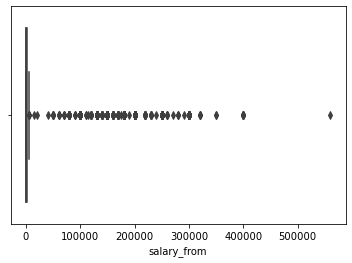

In [64]:
sns.boxplot(x=teleg["salary_from"])

### Добавим валюту

In [65]:
currency = {
    'Usd': ['usd', '\$', 'dollar', 'доллар', 'бакс', 'баксов'],
    'Euro': ['eur', '€', 'евро'],      
    }

tax = {
    'Gross': ['gros', 'грос', 'до налог', 'до вычет'],
    'Net': ['net', 'после налог', 'после вычет', 'на руки', 'чисты']
    }

teleg['cur'] = 'Rub'

for key, value in currency.items():
    for pat in value:
        teleg.loc[teleg.clean_text.str.contains(pat), 'cur'] = key

teleg['tax'] = 'Net'
teleg.loc[teleg.cur != 'Rub', 'tax'] = 'Gross'

# Если налогооблажение указано в явном виде меняем выбор
for key, value in tax.items():
    for pat in value:
        teleg.loc[teleg.clean_text.str.contains(pat), 'tax'] = key
        
teleg['salary_from'] = pd.to_numeric(teleg['salary_from'], errors='ignore').fillna(0)

In [66]:
#teleg['salary_to'] = pd.to_numeric(teleg['salary_to'], errors='ignore')

### Добавим города и страны

C:\Users\mirra\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


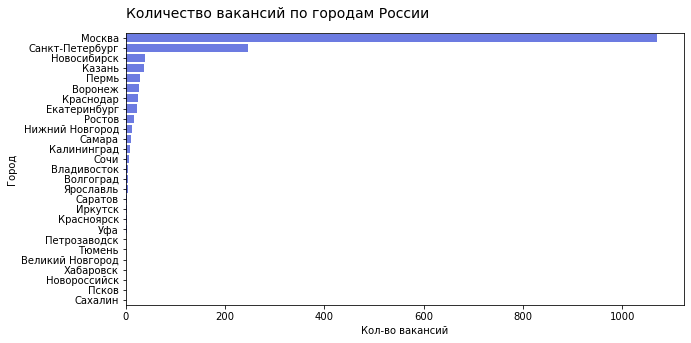

In [67]:
def get_keyword_df(df, keywords):
    for keyword, keywords_to_search in keywords.items():
        keywords_regex = '|'.join(keywords_to_search)
        df[keyword] = df['text'].str.contains(keywords_regex, regex=True)
    keywords_df = pd.DataFrame(columns=['keyword', 'number'])
    for keyword in list(keywords.keys()):
        keywords_df = keywords_df.append({'keyword': keyword, 'number': len(df[df[keyword]])}, ignore_index=True)
    keywords_df = keywords_df.sort_values(by=['number'], ascending=False).reset_index(drop=True)
    keywords_df['perc'] = keywords_df['number'] / len(df) * 100
    return keywords_df

russia_cities = {
    'Москва': ['moscow', '#москва', 'москв[аеы]', 'мск'],
    'Санкт-Петербург': ['saint\Wpetersburg', 'санкт-петербург[ае]?', 'питер[ае]?', 'спб', '#спб'],
    'Казань': ['\Wkazan\W', '\Wказан[ьи]', 'иннополис'],
    'Сочи': ['sochi', 'сочи', 'адлер', '#работавсочи', 'сочинский'],
    'Ростов': ['rostov', 'ростов[ае]?'],
    'Калининград': ['kaliningrad', 'калининград[ае]?'],
    'Самара': ['samara', 'самар[аеы]'],
    'Екатеринбург': ['y?ekaterinburg', 'екатеринбург[ае]?'],
    'Нижний Новгород': ['nizhni?y\Wnovgorod', 'нижн(ий|ем|его) новгород[еа]?'],
    'Краснодар': ['krasnodar', 'краснодаре?'],
    'Иркутск': ['irkutsk', 'иркутск[еа]?'],
    'Ярославль': ['yaroslavl', 'ярославл[ьея]'],
    'Владивосток': ['vladivostok', 'владивосток[ае]?'],
    'Воронеж': ['voronezh', 'воронеж[ае]?'],
    'Петрозаводск': ['petrozavodsk', 'петрозаводск[ае]?'],
    'Тюмень': ['tyumen', 'тюмен[еиь]'],
    'Уфа': ['ufa', '\Wуф[аеы]'],
    'Красноярск': ['krasnoyarsk', 'красноярск[ае]?'],
    'Волгоград': ['volgograd', 'волгоград[ае]?'],
    'Новосибирск': ['novosibirsk', 'новосибирск[ае]?'],
    'Новороссийск': ['novorossiysk', 'новороссийск[ае]?'],
    'Великий Новгород': ['veliki?y?\Wnovgorod', 'велик(ий|ом|ого) новгород[ае]?'],
    'Псков': ['pskov', 'псков[ае]?'],
    'Саратов': ['saratov', 'саратов[ае]?'],
    'Сахалин': ['sakhalin', 'sahalin', 'сахалин[ае]?'],
    'Хабаровск': ['khabarovsk', 'habarovsk', 'хабаровск[ае]?'],\
    'Пермь': ['perm', 'пермь', 'перм[ьи]?'],
}

russia_cities = get_keyword_df(teleg, russia_cities)

columns_city = teleg[['Москва', 'Санкт-Петербург',
       'Казань', 'Сочи', 'Ростов', 'Калининград', 'Самара', 'Екатеринбург',
       'Нижний Новгород', 'Краснодар', 'Иркутск', 'Ярославль', 'Владивосток',
       'Воронеж', 'Петрозаводск', 'Тюмень', 'Уфа', 'Красноярск', 'Волгоград',
       'Новосибирск', 'Новороссийск', 'Великий Новгород', 'Псков', 'Саратов',
       'Сахалин', 'Хабаровск', 'Пермь']]

teleg[['Москва', 'Санкт-Петербург',
       'Казань', 'Сочи', 'Ростов', 'Калининград', 'Самара', 'Екатеринбург',
       'Нижний Новгород', 'Краснодар', 'Иркутск', 'Ярославль', 'Владивосток',
       'Воронеж', 'Петрозаводск', 'Тюмень', 'Уфа', 'Красноярск', 'Волгоград',
       'Новосибирск', 'Новороссийск', 'Великий Новгород', 'Псков', 'Саратов',
       'Сахалин', 'Хабаровск', 'Пермь']] = columns_city.astype('str')

russia_cities.rename(columns={'keyword': 'Город', 'number': 'Количество вакансий', 'perc': 'Процент вакансий'})
plt.figure(figsize=(10, 5))
sns.barplot(data=russia_cities, x='number', y='keyword', color=(0.0, 0.122, 0.94), orient='h', alpha=0.65)
plt.title(label='Количество вакансий по городам России', loc='left', size=14, pad=15)
plt.xlabel('Кол-во вакансий')
plt.ylabel('Город')
plt.show()

def RF_cities(row):
    Москва = row['Москва']
    Санкт_Петербург = row['Санкт-Петербург']
    Новосибирск = row['Новосибирск']
    Екатеринбург = row['Екатеринбург']
    Казань = row['Казань']
    Воронеж = row['Воронеж']
    Сочи = row['Сочи']
    Ростов = row['Ростов']
    Нижний_Новгород = row['Нижний Новгород']
    Краснодар = row['Краснодар']
    Пермь = row['Пермь']
    if 'True' in Москва:
        return 'Москва'
    elif 'True' in Санкт_Петербург:
        return 'Санкт-Петербург'
    elif 'True' in Новосибирск:
        return 'Новосибирск'
    elif 'True' in Новосибирск:
        return 'Новосибирск'
    elif 'True' in Екатеринбург:
        return 'Екатеринбург'
    elif 'True' in Казань:
        return 'Казань'
    elif 'True' in Воронеж:
        return 'Воронеж'
    elif 'True' in Сочи:
        return 'Сочи'
    elif 'True' in Ростов:
        return 'Ростов'
    elif 'True' in Нижний_Новгород:
        return 'Нижний Новгород'
    elif 'True' in Краснодар:
        return 'Краснодар'
    elif 'True' in Пермь:
        return 'Пермь'
    else:
        return 'Не указан'

teleg['RF_cities'] = teleg.apply(RF_cities, axis=1)
teleg = teleg.drop(['Москва', 'Санкт-Петербург',
       'Казань', 'Сочи', 'Ростов', 'Калининград', 'Самара', 'Екатеринбург',
       'Нижний Новгород', 'Краснодар', 'Иркутск', 'Ярославль', 'Владивосток',
       'Воронеж', 'Петрозаводск', 'Тюмень', 'Уфа', 'Красноярск', 'Волгоград',
       'Новосибирск', 'Новороссийск', 'Великий Новгород', 'Псков', 'Саратов',
       'Сахалин', 'Хабаровск', 'Пермь'], axis=1)

In [68]:
#columns_city.columns

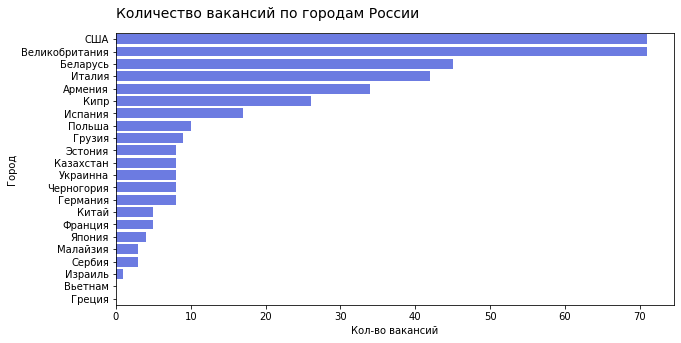

In [69]:
countries = {
    'США': ['usa', 'америк[у]', 'штаты[тов]', 'сша', 'нью\Wйорк'],
    'Великобритания': ['uk', 'london', 'лондон[уеа]', 'великобритани[яю]'],
    'Израиль': ['israel', 'израиль','израил[ю]'],
    'Франция': ['france', 'paris', 'париж','франци[яю]'],
    'Германия': ['germany', 'berlin', 'берлин[ау]', '#германия', 'германи[яю]'],
    'Испания': ['spain', '#spain', 'barcelona', 'malaga', 'madrid', 'sevilla', 'valencia', 'барселон[ау]','мадрид[ау]', 'испани[яю]'],
    'Италия': ['italy', 'rome', 'рим[ау]','итали[яю]'],
    'Япония': ['japan', 'tokyo', 'токио','япония[яю]'],
    'Китай': ['china', 'pekin', 'пекин[ау]','кита[йяю]'],
    'Bьетнам': ['vietnam', 'вьетнам[у]'],
    'Кипр': ['сyprus', '#сyprus', 'кипр[уе]','#кипр', 'лимассол', '#лимассол'],
    'Греция': ['greece', '#greece', 'герци[яю]'],
    'Эстония': ['estonia', 'tallin', 'эстони[яю]','таллин'],
    'Беларусь': ['belarus', 'minsk', 'Беларус[ию]' 'беларусь', 'минск'],
    'Украинна': ['ukraina', 'kiev', 'украин[ау]','киев[у]', 'харьков', 'гомель'],
    'Малайзия': ['malaysia', '#malaysia', 'kuala\Wlumpur', 'малайзи[яю]'],
    'Сербия': ['serbia', '#serbia', 'серби[яию]'],
    'Польша': ['poland', '#poland', 'польш[ае]', 'варшав[ау]'],
    'Казахстан': ['kazakhstan', '#kazakhstan', 'казахстан[е]'],
    'Грузия': ['georgia', '#georgia', 'грузи[яию]', 'тбилиси', 'tbilisi'],
    'Армения': ['armenia', '#armenia', 'армени[яию]', 'ереван[еу]', 'yerevan'],
    'Черногория': ['montenegro', '#montenegro', 'черногори[яию]'],
} 

countries = get_keyword_df(teleg, countries)


columns_countries = teleg[['США','Великобритания','Израиль','Франция','Германия','Испания', 'Италия','Япония',
                           'Китай','Bьетнам','Кипр', 'Греция', 'Эстония', 'Беларусь', 'Украинна',
                           'Малайзия', 'Сербия', 'Польша', 'Казахстан', 'Грузия', 'Армения', 'Черногория']]

teleg[['США','Великобритания','Израиль','Франция','Германия','Испания', 'Италия','Япония','Китай','Bьетнам','Кипр', 'Греция', 'Эстония', 'Беларусь', 'Украинна', 'Малайзия', 'Сербия',
       'Польша', 'Казахстан', 'Грузия', 'Армения', 'Черногория']] = columns_countries.astype('str')

countries.rename(columns={'keyword': 'Город', 'number': 'Количество вакансий', 'perc': 'Процент вакансий'})
plt.figure(figsize=(10, 5))
sns.barplot(data=countries, x='number', y='keyword', color=(0.0, 0.122, 0.94), orient='h', alpha=0.65)
plt.title(label='Количество вакансий по городам России', loc='left', size=14, pad=15)
plt.xlabel('Кол-во вакансий')
plt.ylabel('Город')
plt.show()

def countries(row):
    США = row['США']
    Великобритания = row['Великобритания']
    Израиль = row['Израиль']
    Франция = row['Франция']
    Германия = row['Германия']
    Испания = row['Испания']
    Италия = row['Италия']
    Япония = row['Япония']
    Китай = row['Китай']
    Кипр = row['Кипр']
    Эстония = row['Эстония']
    Беларусь = row['Беларусь']
    Украинна = row['Украинна']
    Малайзия = row['Малайзия']
    Сербия = row['Сербия']
    Польша = row['Польша']
    Казахстан = row['Казахстан']
    Грузия = row['Грузия']
    Армения = row['Армения']
    Черногория = row['Черногория']
    
    if 'True' in США:
        return 'США'
    elif 'True' in Великобритания:
        return 'Великобритания'
    elif 'True' in Израиль:
        return 'Израиль'
    elif 'True' in Франция:
        return 'Франция'
    elif 'True' in Германия:
        return 'Германия'
    elif 'True' in Испания:
        return 'Испания'
    elif 'True' in Италия:
        return 'Италия'
    elif 'True' in Япония:
        return 'Япония'
    elif 'True' in Китай:
        return 'Китай'
    elif 'True' in Кипр:
        return 'Кипр'
    elif 'True' in Эстония:
        return 'Эстония'
    elif 'True' in Беларусь:
        return 'Беларусь'
    elif 'True' in Украинна:
        return 'Украинна'
    elif 'True' in Малайзия:
        return 'Малайзия'
    elif 'True' in Сербия:
        return 'Сербия'
    elif 'True' in Польша:
        return 'Польша'
    elif 'True' in Казахстан:
        return 'Казахстан'
    elif 'True' in Грузия:
        return 'Грузия'
    elif 'True' in Армения:
        return 'Армения'
    elif 'True' in Черногория:
        return 'Черногория'
    else:
        return 'Россия'

teleg['countries'] = teleg.apply(countries, axis=1)
teleg = teleg.drop(['США','Великобритания','Израиль','Франция','Германия','Испания', 'Италия','Япония',
                           'Китай','Bьетнам','Кипр', 'Греция', 'Эстония', 'Беларусь', 'Украинна',
                           'Малайзия', 'Сербия', 'Польша', 'Казахстан', 'Грузия', 'Армения', 'Черногория'], axis=1)

### Подготавливаем итоговый датафрейм к выгрузке в Tableau

In [70]:
# Удаляем ненужные колонки из датафрейма
teleg_tableau = teleg.drop(['chat', 'text', 'entities', 'message_id', 'clean_text'], axis=1)
teleg_tableau.head(2)

,0,Unnamed: 0,chat_id,date,position_name,title,vac_name,vac_name_2,positions_da,positions_ds,...,sphere,brand_name,salarry_not_show,salary,salary_from,salary_to,cur,tax,RF_cities,countries
1,NaN,1.0,-1.001483e+12,2022-06-10,ds,"Data jobs — вакансии по data science, анализу ...",data scientist мигас работа в офисе от ...,data scientist,"Вакансии DS, DE",Data Scientist,...,Другое,Другое,False,"[('', '', '150 000')]",0.0,,Rub,Net,Не указан,Россия
3,NaN,3.0,-1.001483e+12,2022-06-08,ds,"Data jobs — вакансии по data science, анализу ...",data scientist мвс груп работа в офисе за...,data scientist,"Вакансии DS, DE",Data Scientist,...,Другое,Другое,True,[],0.0,,Rub,Net,Не указан,Россия


In [71]:
teleg_tableau_20_06 = teleg_tableau.to_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Пасека\Парсер вакансий в Телеграм\final_one\teleg_tableau_20_06.csv')

# 2. Исследовательский анализ данных

## Задачи:

- Определить навыки

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Комментарий студента:</b> 
    
В данной работе в качестве навыков выделяю только hard-skills, они в тексте вакансии прописаны латинскими буквами, поэтому рассматривала методы подсчета слов и определения языка. Пробовала несколько способов, но от части в итоге отказалась (код не удаляла, он закомментирован). 
 
#### 1) One-hot кодирование 
    
После выделения векторов, кодирования и подсчета слов получилось 36438 значений. Такой вариант сложно анализировать, он не подошел.
    
#### 2) Лемматизация
    
После применения лемматизации количество значений снизилось до 26375. Но сложности возникли с определением языка, я использовала language_detection, он справляется с фразами, предложениями, текстами, то отдельно слово далеко не всегда определяеr корректно. 

#### 3) Функция word_tokenize
    
Лучше всего подошел этот вариант, но свои сложности были - большой стоп-лист, который пришлось делать вручную. Можно было бы ограничить количество слов самыми часто встречаемыми, но у каждого типа вакансии он свой.
    
    
### (!)
    
Кроме того, анализ навыков - это отдельный датафрейм. 
    Так как пожелание заказчика - увидеть навыки в разрезе грейдов, пришлось поделись датафрейм на грейды и к каждому применить word_tokenize, а потом объединить. Плюс сделать один общий skill-list для каждого типа (de, da, ds), т.к. у бОльшего количество вакансий грейд не указан, поэтому общая картина все-таки нагляднее.    

</div>

### 1. One-hot кодирование слов 

In [72]:
# words  = list(teleg['text']) 

# label_encoder = LabelEncoder()
# corpus_encoded = label_encoder.fit_transform(words)
# corpus_encoded

In [73]:
# onehot_encoder = OneHotEncoder(sparse=False)
# onehot_encoder.fit_transform(corpus_encoded.reshape(-1, 1))

In [74]:
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer=CountVectorizer()

# vectorizer.fit(words)

In [75]:
# vectors = vectorizer.transform(words)

# vectors.todense()

In [76]:
# world_list = vectorizer.vocabulary_
# world_list

In [77]:
# #преобразуем словарь в датафрейм
# world_df = pd.DataFrame(list(world_list.items()), columns=['world', 'count'])

# #удаляем из полученного df цифры (но сначала их преобразуем)
# world_df['digital'] = world_df['world']
# world_df['digital'] = pd.to_numeric(world_df['digital'], errors='coerce').fillna(0).astype('int')
# world_only = world_df.query('digital == 0')
# #world_df.info()
# world_only.info()

In [78]:
# def tex_len(row):
#     text = len(row['world'])
#     return text

# world_only['len'] = world_only.apply(tex_len, axis=1)
# world_only.head()

# world_only = world_only.query('len > 3')
# world_only

### 2. Лемматизация и подсчет слов

In [79]:
# words_list  = str(list(teleg['text']))

# regex = re.compile(r'(\W)\1+')
# words_list = regex.sub(r'\1', words_list)

# regex = re.compile(r'[^\w\s]')
# words_list=regex.sub(r' ', words_list).strip()

# regex = re.compile(r'[0-9]')
# words_list=regex.sub(r' ', words_list).strip()

In [80]:
# m = Mystem()
# for_lemmas = words_list
# #lemma = ' '.join(for_lemma)
# lemma_finals = m.lemmatize(for_lemmas)
# #display(lemmas_final)
# #display(Counter(lemmas_final))
# world_lemmas = Counter(lemma_finals)

# world_lemmas = pd.DataFrame(list(world_lemmas.items()), columns=['world', 'count']).sort_values(by='count', ascending=False)
# #world_lemmas.head(15)

In [81]:
#world_lemmas.info()
#world_lemmas.head(30)

In [82]:
# def text_len(row):
#     text = len(row['world'])
#     return text

# world_lemmas['len'] = world_lemmas.apply(text_len, axis=1)
# world_lemmas = world_lemmas.query('len > 3 & count > 5').sort_values(by='count', ascending=False)
# #world_lemmas.head(30)
# # не стала сбрасывать индекс, потому что выдает ошибку

In [83]:
#world_lemmas.to_csv('world_lemmas.csv')

In [84]:
# def language_detection(text):
#     try:
#         return detect(text)
#     except:
#         return None

# world_lemmas['language'] = world_lemmas['world'].apply(language_detection)

In [85]:
#world_lemmas.query('language != "ru"').head(10)

### WordCloud 

In [86]:
#pip install wordcloud
#nltk.download('punkt')

In [87]:
# a = teleg['text'].str.lower().str.cat(sep=' ')

# # removes punctuation,numbers and returns list of words
# b = re.sub('[^A-Za-z]+', ' ', a)

# #STOPWORDS.add('https', 'proglib') 
# stop_words = ['https', 'proglib', 'with', 'fulltime', 'engineer', 'remote', 'middle', 'data', 
#               'and', 'senior', 'the', 'for', 'com', 'science', 'our', 'scientist', 'vacancy', 'vacancies',  
#               'junior', 'analytics', 'you', 'job', 'skills', 'time', 'work', 'etc', 'company',
#              'tinkoff', 'experience', 'developer', 'dataengineer', 'knowledge', 'analyst', 'team',
#              'business', 'product', 'lead', 'devops', 'full', 'gross', 'are', 'working'] 
# word_tokens = word_tokenize(b)

# sentence = []
# for w in word_tokens:
#     if w not in stop_words:
#         sentence.append(w)

# # Remove characters which have length less than 2  
# without_single_chr = [word for word in sentence if len(word) > 2]

# # Remove numbers
# cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# # Calculate frequency distribution
# word_dist = nltk.FreqDist(cleaned_data_title)
# rslt = pd.DataFrame(list(word_dist.items()), columns=['Word', 'Frequency'])

# plt.figure(figsize=(15,5))
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(20))

In [88]:
# def wc(data,bgcolor,title):
#     plt.figure(figsize = (100,100))
#     wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
#     wc.generate(' '.join(data))
#     plt.imshow(wc)
#     plt.axis('off')
    
# wc(cleaned_data_title,'black','Frequent Words')    

### 3. Функция word_tokenize

### Вакансии DE
####  Подсчет слов и определения ключевых навыков по вакансиям

In [89]:
de_vac = teleg.query('position_name == "de"')

In [90]:
# список слов, которые не определяют навыки кандидата на вакансию
stop_words = ['https', 'proglib', 'with', 'fulltime', 'engineer', 'remote', 'middle', 'data', 
              'and', 'senior', 'the', 'for', 'com', 'science', 'our', 'scientist', 'vacancy', 'vacancies',  
              'junior', 'analytics', 'you', 'job', 'skills', 'time', 'work', 'etc', 'company',
             'tinkoff', 'experience', 'developer', 'dataengineer', 'knowledge', 'analyst', 'team',
             'business', 'product', 'lead', 'devops', 'full', 'gross', 'are', 'working', 'learning',
             'development', 'strong', 'from', 'will', 'computer', 'learn', 'analysis', 'to', 'of', 'in', 
              'ru', 'it', 'on', 'or', 'is', 'we', 'as', 'hr', 'be', 'cv', 'ds', 'platform', 'engineering',
             'at', 'hh', 'have', 'www', 'solutions', 'geekjob', 'intermediate', 'server', 'requirements', 
              'office', 'years', 'group', 'management', 'that', 'an', 'services', 'code', 'datascience',
             'web', 'vision', 'dl', 'new', 'software', 'telegram', 'scientists', 'big', 'io', 'net',
             'ms', 'cd', 'cpp', 'quality', 'open', 'world', 'using', 'google', 'yandex', 'cloud',
             'end', 'datascientist', 'streaming', 'qa', 'mobile', 'me', 'digital', 'sense', 'tg', 'processing',
             'tech', 'ad', 'salary', 'technologies', 'looking', 'your', 'ai', 'microsoft', 'deep', 'core', 'hoc',
             'system', 'join', 'one', 'machine', 'mail', 'technical', 'other', 'responsibilities', 'systems',
             'develop', 'models', 'tools', 'by', 'plus', 'ph', 'relocation', 'all', 'telega', 'teams',
             'offer', 'rnd', 'olga', 'mudalova', 'mari', 'udalova', 'best', 'beeline', 'jobforjunior', 'intelligence',  
              'spb', 'masking', 'amplitude', 'databricks', 'dns', 'kamagames', 'ga', 
              'security', 'manager', 'dataanalyst', 'manager', 'off', 'compliance', 'ibm', 'app', 
              'ozon', 'helastel', 'moscow', 'database', 'do', 'environment', 'innovative', 'productanalyst',
              'distributed','engines','studio','metrics','clck','performance','interesting', 'productanalyst',
             'building', 'skyeng', 'like', 'unit','products', 'high', 'analytical', 'client', 'pepsico', 'fivetran', 
              'supply', 'chain','analytical','head','customer','across','use','service','based','drive','driven','up',
              'stock','stakeholders','good','home','their','building','decisions','through','this','like','support',
              'complex','recommendation','studyfree','make','marketing','sales','day','zencastr','store',
              'quantitative', 'students', 'analitik', 'lake', 'dax', 'commerce', 'gtm', 'origination','reports',
              'journey','php','mpp','wa','wazzup','drivematics','rusprofile','retention','kanban','travel',
              'role','finance','xml','zimad','smart','id','analysts','mil','erp','ventra','powerbipoint',
              'webium','terrasoft','sheets','dashboard','arpu','framework','start','highload','redshift','daily','hays','owner',
              'fluent','go','governance','mvp','fintech','cm','amazon','teamcity','sre','jobs','production','ability','atlassian',
              'dlp','soap','scrum','reporting','mdx','fix','source','prm','redash','about','iqbi',
              'epc','http','dolgova','center','appmetrica','project','gett','microstrategy','bitbucket','christinch','facebook','retail',
              'vba','edtech','boot','coursera','ux','games','expert','vk','artemovna','reilly',
              'newhr','kpi','insights','upper','tabular','dashboards','dannyh','email','tag','informatica','javascript','kubernetes','ansible','part','enterprise','ssrs','fmcg','js','pro',
              'ui','json', 'decision', 'marina', 'platinum', 'gpu','niko', 'engineers', 'snezhanamts', 'mtsbigdata', 'fulltimejob',
              'rollout','rub','detection','object', 'fulltimejob', 'detection', 'object', 
              'asr', 'promo', 'telegra', 'upper', 'head', 'teamlead', 'mining', 'telegra'] #LAST_19_5_12_38

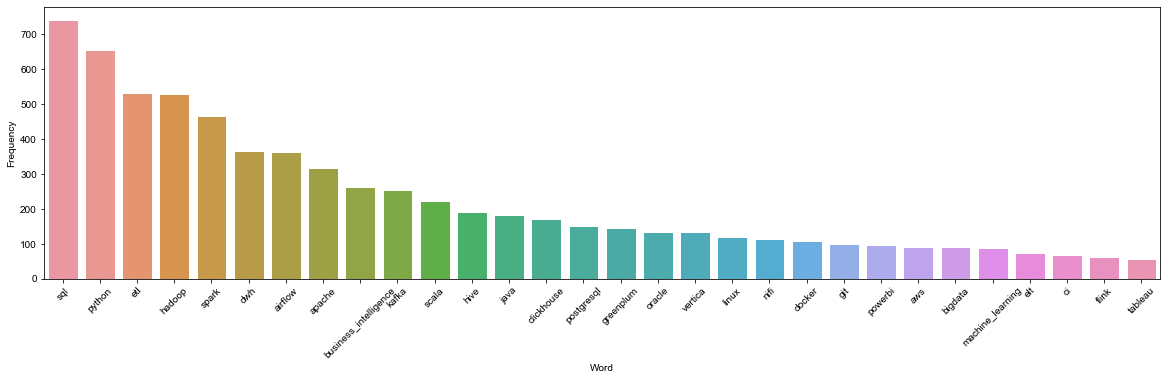

In [91]:
a_de = (de_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_de = re.sub('[^A-Za-z]+', ' ', a_de)

word_tokens_de = word_tokenize(b_de)

sentence = []
for w in word_tokens_de:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_de = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_de = [word for word in without_single_chr_de if not word.isnumeric()]        

# Посчитаем слова
words_de = nltk.FreqDist(cleaned_data_de)
rslt_de = (
    pd.DataFrame(list(words_de.items()), columns=['Word', 'Frequency'])
    .sort_values(by='Frequency', ascending=False)
    .query('Frequency > 3')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

plt.figure(figsize=(20,5))
plt.xticks(rotation = 45)
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt_de.head(30))

In [92]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,80))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')
    
#wc(cleaned_data_de,'black','Frequent Words') 

In [93]:
# определяем тип навыка - добавим столбцы, для того, чтобы определить к какой компетенции относится навык 
# куда правильно отнести airflow и nifi?

various_tasks = r'python|pandas|numpy|scipy|sql|git|google|api|excel'
vizualization = r'tableau|power_bi|seaborn|matplotlib|powerbi|matplotlib|grafana'
bi_tool = r'bi|qlik|powerbi|olap|sas'
cloud_computaring = r'aws|azure|bigquery|cloud'
stream_processing = r'hadoop|scala|hive|kafka|apache|spark|impala|flink'
database = r'etl|oracle|sap|greenplum|sql|postgresql|postgres|nosql|mysql|dwh|clickhouse|vertica|sap|mongodb|hbase|ssas|ssis '
etl_elt_tools = r'etl|elt|nifi|airflow'
maching_learning = r'machine_learning|tensorflow|pytorch|nlp|sklearn|ai|sklearn|scikit|keras'
software = r'docker|kubernetes|jira|sap|confluence'
operation_system = r'linux|android|ios|bash'
programming_lang = r'python|go|java|ci|kotlin|js'
other = r'mapreduce|xgboost|agile|gitlab|design|crm|rest|english'

#LAST_17_5_12_32
rslt_de['position_name'] = 'de'

rslt_de['various_tasks'] = rslt_de['Word'].apply(lambda x: True if re.search(various_tasks, x.lower()) else False)
rslt_de['vizualization'] = rslt_de['Word'].apply(lambda x: True if re.search(vizualization, x.lower()) else False)
rslt_de['bi_tool'] = rslt_de['Word'].apply(lambda x: True if re.search(bi_tool, x.lower()) else False)
rslt_de['cloud_computaring'] = rslt_de['Word'].apply(lambda x: True if re.search(cloud_computaring, x.lower()) else False)
rslt_de['stream_processing'] = rslt_de['Word'].apply(lambda x: True if re.search(stream_processing, x.lower()) else False)
rslt_de['database'] = rslt_de['Word'].apply(lambda x: True if re.search(database, x.lower()) else False)
rslt_de['etl_elt_tools'] = rslt_de['Word'].apply(lambda x: True if re.search(etl_elt_tools, x.lower()) else False)
rslt_de['maching_learning'] = rslt_de['Word'].apply(lambda x: True if re.search(maching_learning, x.lower()) else False)
rslt_de['software'] = rslt_de['Word'].apply(lambda x: True if re.search(software, x.lower()) else False)
rslt_de['operation_system'] = rslt_de['Word'].apply(lambda x: True if re.search(operation_system, x.lower()) else False)
rslt_de['programming_lang'] = rslt_de['Word'].apply(lambda x: True if re.search(programming_lang, x.lower()) else False)
rslt_de['other'] = rslt_de['Word'].apply(lambda x: True if re.search(other, x.lower()) else False)

rslt_de = rslt_de.head(60)
rslt_de
#LAST_17_5_11_21

,Word,Frequency,position_name,various_tasks,vizualization,bi_tool,cloud_computaring,stream_processing,database,etl_elt_tools,maching_learning,software,operation_system,programming_lang,other
0,sql,740,de,True,False,False,False,False,True,False,False,False,False,False,False
1,python,654,de,True,False,False,False,False,False,False,False,False,False,True,False
86,etl,531,de,False,False,False,False,False,True,True,False,False,False,False,False
9,hadoop,528,de,False,False,False,False,True,False,False,False,False,False,False,False
11,spark,466,de,False,False,False,False,True,False,False,False,False,False,False,False
37,dwh,365,de,False,False,False,False,False,True,False,False,False,False,False,False
3,airflow,361,de,False,False,False,False,False,False,True,True,False,False,False,False
10,apache,316,de,False,False,False,False,True,False,False,False,False,False,False,False
82,business_intelligence,263,de,False,False,False,False,False,False,False,False,False,False,False,False
8,kafka,253,de,False,False,False,False,True,False,False,False,False,False,False,False


In [94]:
rslt_de_20_5 = rslt_de.to_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Пасека\Парсер вакансий в Телеграм\final_one\rslt_de_20-5_12-33.csv')

In [95]:
#rslt_de[rslt_de['vizualization'] == True]

In [96]:
#teleg.head(2)

In [97]:
de_jun_vac = teleg.query('position_name == "de" and grade == "Junior" ')

a_de_jun = (de_jun_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_de_jun = re.sub('[^A-Za-z]+', ' ', a_de_jun)

word_tokens_de_jun = word_tokenize(b_de_jun)

sentence = []
for w in word_tokens_de_jun:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_de_jun = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_de_jun = [word for word in without_single_chr_de_jun if not word.isnumeric()]        

# Посчитаем слова
words_de_jun = nltk.FreqDist(cleaned_data_de_jun)
rslt_de_jun = (
    pd.DataFrame(list(words_de_jun.items()), columns=['Word', 'Frequency_junior'])
    .sort_values(by='Frequency_junior', ascending=False)
    .query('Frequency_junior > 3')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_de_jun['Junior'] = 'Junior'
#rslt_de_jun

In [98]:
de_jun_plus_vac = teleg.query('position_name == "de" and grade == "Junior_plus" ')

a_de_jun_plus = (de_jun_plus_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_de_jun_plus = re.sub('[^A-Za-z]+', ' ', a_de_jun_plus)

word_tokens_de_jun_plus = word_tokenize(b_de_jun_plus)

sentence = []
for w in word_tokens_de_jun_plus:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_de_jun_plus = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_de_jun_plus = [word for word in without_single_chr_de_jun_plus if not word.isnumeric()]        

# Посчитаем слова
words_de_jun_plus = nltk.FreqDist(cleaned_data_de_jun_plus)
rslt_de_jun_plus = (
    pd.DataFrame(list(words_de_jun_plus.items()), columns=['Word', 'Frequency_junior_plus'])
    .sort_values(by='Frequency_junior_plus', ascending=False)
    .query('Frequency_junior_plus > 3')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun_plus.head(30))


rslt_de_jun_plus['Junior_plus'] = 'Junior_plus'
#rslt_de_jun_plus

In [99]:
de_middle_vac = teleg.query('position_name == "de" and grade == "Middle" ')

a_de_middle = (de_middle_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_de_middle = re.sub('[^A-Za-z]+', ' ', a_de_middle)

word_tokens_de_middle = word_tokenize(b_de_middle)

sentence = []
for w in word_tokens_de_middle:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_de_middle = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_de_middle = [word for word in without_single_chr_de_middle if not word.isnumeric()]        

# Посчитаем слова
words_de_middle = nltk.FreqDist(cleaned_data_de_middle)
rslt_de_middle = (
    pd.DataFrame(list(words_de_middle.items()), columns=['Word', 'Frequency_middle'])
    .sort_values(by='Frequency_middle', ascending=False)
    .query('Frequency_middle > 3').reset_index()
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun_plus.head(30))

rslt_de_middle['Middle'] = 'Middle'
#rslt_de_middle

In [100]:
de_middle_plus_vac = teleg.query('position_name == "de" and grade == "Middle_plus" ')

a_de_middle_plus = (de_middle_plus_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_de_middle_plus = re.sub('[^A-Za-z]+', ' ', a_de_middle_plus)

word_tokens_de_middle_plus = word_tokenize(b_de_middle_plus)

sentence = []
for w in word_tokens_de_middle_plus:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_de_middle_plus = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_de_middle_plus = [word for word in without_single_chr_de_middle_plus if not word.isnumeric()]        

# Посчитаем слова
words_de_middle_plus = nltk.FreqDist(cleaned_data_de_middle_plus)
rslt_de_middle_plus = (
    pd.DataFrame(list(words_de_middle_plus.items()), columns=['Word', 'Frequency_middle_plus'])
    .sort_values(by='Frequency_middle_plus', ascending=False)
    .query('Frequency_middle_plus > 5').reset_index()
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun_plus.head(30))

rslt_de_middle_plus['Middle_plus'] = 'Middle_plus'
#rslt_de_middle_plus

In [101]:
de_senior_vac = teleg.query('position_name == "de" and grade == "Senior" ')

a_de_senior = (de_senior_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_de_senior = re.sub('[^A-Za-z]+', ' ', a_de_senior)

word_tokens_de_senior = word_tokenize(b_de_senior)

sentence = []
for w in word_tokens_de_senior:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_de_senior = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_de_senior = [word for word in without_single_chr_de_senior if not word.isnumeric()]        

# Посчитаем слова
words_de_senior = nltk.FreqDist(cleaned_data_de_senior)
rslt_de_senior = (
    pd.DataFrame(list(words_de_senior.items()), columns=['Word', 'Frequency_senior'])
    .sort_values(by='Frequency_senior', ascending=False)
    .query('Frequency_senior > 5').reset_index()
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun_plus.head(30))

rslt_de_senior['Senior'] = 'Senior'
#rslt_de_senior

In [102]:
de_lead_vac = teleg.query('position_name == "de" and grade == "Lead" ')

a_de_lead = (de_lead_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_de_lead = re.sub('[^A-Za-z]+', ' ', a_de_lead)

word_tokens_de_lead = word_tokenize(b_de_lead)

sentence = []
for w in word_tokens_de_lead:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_de_lead = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_de_lead = [word for word in without_single_chr_de_lead if not word.isnumeric()]        

# Посчитаем слова
words_de_lead = nltk.FreqDist(cleaned_data_de_lead)
rslt_de_lead = (
    pd.DataFrame(list(words_de_lead.items()), columns=['Word', 'Frequency_lead'])
    .sort_values(by='Frequency_lead', ascending=False)
    .query('Frequency_lead > 5').reset_index()
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun_plus.head(30))

rslt_de_lead['Lead'] = 'Lead'
#rslt_de_lead

In [103]:
de_nograde_vac = teleg.query('position_name == "de" and grade == "Не указан" ')

a_de_nograde = (de_nograde_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_de_nograde = re.sub('[^A-Za-z]+', ' ', a_de_nograde)

word_tokens_de_nograde = word_tokenize(b_de_nograde)

sentence = []
for w in word_tokens_de_nograde:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_de_nograde = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_de_nograde = [word for word in without_single_chr_de_nograde if not word.isnumeric()]        

# Посчитаем слова
words_de_nograde = nltk.FreqDist(cleaned_data_de_nograde)
rslt_de_nograde = (
    pd.DataFrame(list(words_de_nograde.items()), columns=['Word', 'Frequency_nograde'])
    .sort_values(by='Frequency_nograde', ascending=False)
    .query('Frequency_nograde > 5').reset_index()
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun_plus.head(30))

rslt_de_nograde['no_grade'] = 'Не указан'
#rslt_de_nograde

In [104]:
rslt_de_total = rslt_de_jun.merge(rslt_de_jun_plus, on='Word', how='outer').fillna(0)
rslt_de_total = rslt_de_total.merge(rslt_de_middle, on='Word', how='outer').fillna(0)
rslt_de_total = rslt_de_total.merge(rslt_de_middle_plus, on='Word', how='outer').fillna(0)
rslt_de_total = rslt_de_total.merge(rslt_de_senior, on='Word', how='outer').fillna(0)
rslt_de_total = rslt_de_total.merge(rslt_de_lead, on='Word', how='outer').fillna(0)
rslt_de_total = rslt_de_total.merge(rslt_de_nograde, on='Word', how='outer').fillna(0)

rslt_de_total['Frequency_junior'] = rslt_de_total['Frequency_junior'].astype('int')
rslt_de_total['Frequency_junior_plus'] = rslt_de_total['Frequency_junior_plus'].astype('int')
rslt_de_total['Frequency_middle'] = rslt_de_total['Frequency_middle'].astype('int')
rslt_de_total['Frequency_middle_plus'] = rslt_de_total['Frequency_middle_plus'].astype('int')
rslt_de_total['Frequency_senior'] = rslt_de_total['Frequency_senior'].astype('int')
rslt_de_total['Frequency_lead'] = rslt_de_total['Frequency_lead'].astype('int')
rslt_de_total['Frequency_nograde'] = rslt_de_total['Frequency_nograde'].astype('int')

rslt_de_total['Frequency_total'] = (
    rslt_de_total['Frequency_junior'] + rslt_de_total['Frequency_junior_plus']
    + rslt_de_total['Frequency_middle'] + rslt_de_total['Frequency_middle_plus']
     + rslt_de_total['Frequency_senior'] + rslt_de_total['Frequency_lead'] + rslt_de_total['Frequency_nograde']
)

rslt_de_total = rslt_de_total.drop(['index_x', 'index_y'],axis=1).reset_index(drop=True)
#reset_index(drop=True, inplace=True)
rslt_de_total['position_name'] = 'de'
rslt_de_total = rslt_de_total.query('Frequency_total > 15')
rslt_de_total.sort_values(by='Frequency_total', ascending=False).tail(40)


,Word,Frequency_junior,Junior,Frequency_junior_plus,Junior_plus,Frequency_middle,Middle,Frequency_middle_plus,Middle_plus,Frequency_senior,Senior,Frequency_lead,Lead,index,Frequency_nograde,no_grade,Frequency_total,position_name
150,compensation,0,0,0,0,0,0,0,0,0,0,0,0,341.0,22,Не указан,22,de
149,confluence,0,0,0,0,0,0,0,0,0,0,0,0,359.0,22,Не указан,22,de
126,able,0,0,0,0,0,0,0,0,0,0,21,Lead,0.0,0,0,21,de
5,cloudera,9,Junior,0,0,0,0,0,0,0,0,0,0,572.0,12,Не указан,21,de
151,query,0,0,0,0,0,0,0,0,0,0,0,0,73.0,21,Не указан,21,de
152,clever,0,0,0,0,0,0,0,0,0,0,0,0,286.0,21,Не указан,21,de
153,recruiting,0,0,0,0,0,0,0,0,0,0,0,0,287.0,21,Не указан,21,de
96,pyspark,0,0,0,0,0,0,7,Middle_plus,0,0,0,0,549.0,13,Не указан,20,de
114,developing,0,0,0,0,0,0,0,0,7,Senior,0,0,291.0,13,Не указан,20,de
89,saas,0,0,0,0,0,0,10,Middle_plus,0,0,0,0,85.0,10,Не указан,20,de


In [105]:
#rslt_de_total_10_6 = rslt_de_total.to_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Пасека\Парсер вакансий в Телеграм\final_one\rslt_de_total_10_6.csv')

## Вакансии DA
####  Подсчет слов и определения ключевых навыков по вакансиям

In [106]:
da_vac = teleg.query('position_name == "da"').reset_index()
#da_vac.head()

In [107]:
#print(da_vac.iloc[2]['text'])

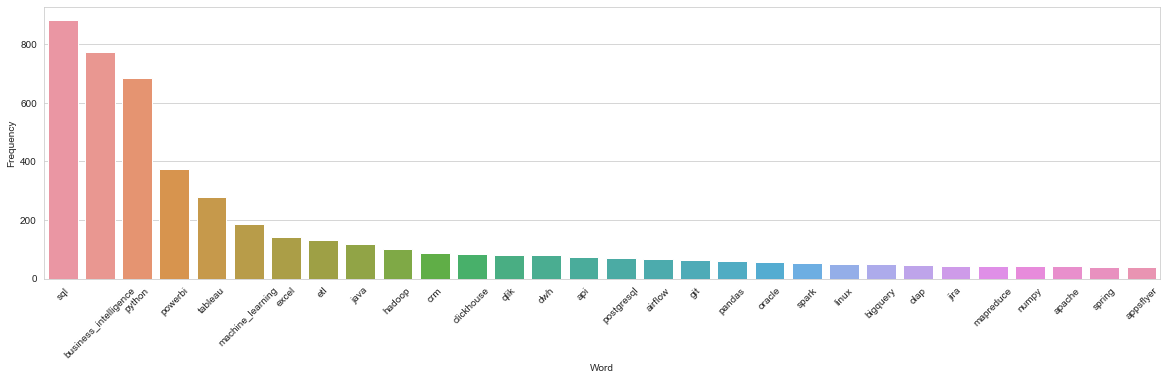

In [108]:
a_da = (da_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        #.replace('ml', 'machine_learning')
        #.replace('machine', 'machine_learning')
        .replace('deep', 'deep_learning')
       )

# удалим пунктуацию
b_da = re.sub('[^A-Za-z]+', ' ', a_da)

word_tokens_da = word_tokenize(b_da)

sentence = []
for w in word_tokens_da:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_da = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_da  = [word for word in without_single_chr_da if not word.isnumeric()]        

# Посчитаем слова
words_da = nltk.FreqDist(cleaned_data_da)
rslt_da = (
    pd.DataFrame(list(words_da.items()), columns=['Word', 'Frequency'])
    .sort_values(by='Frequency', ascending=False)
    .query('Frequency > 3')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')

plt.figure(figsize=(20,5))
plt.xticks(rotation = 45)
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt_da.head(30))

In [109]:
#wc(cleaned_data_da,'black','Frequent Words') 

In [110]:
# определяем тип навыка - добавим столбцы, для того, чтобы определить к какой компетенции относится навык 
# куда правильно отнести airflow и nifi?

various_tasks = r'python|pandas|numpy|scipy|sql|git|google|api|excel'
vizualization = r'tableau|power_bi|seaborn|matplotlib|powerbi|matplotlib|grafana'
bi_tool = r'bi|qlik|powerbi|olap|sas'
cloud_computaring = r'aws|azure|bigquery|cloud'
stream_processing = r'hadoop|scala|hive|kafka|apache|spark|impala|flink'
database = r'etl|oracle|sap|greenplum|sql|postgresql|postgres|nosql|mysql|dwh|clickhouse|vertica|sap|mongodb|hbase|ssas|ssis '
etl_elt_tools = r'etl|elt|nifi|airflow'
maching_learning = r'machine_learning|tensorflow|pytorch|nlp|sklearn|ai|sklearn|scikit|keras'
software = r'docker|kubernetes|jira|sap|confluence'
operation_system = r'linux|android|ios|bash'
programming_lang = r'python|go|java|ci|kotlin|js'
other = r'mapreduce|xgboost|agile|gitlab|design|crm|rest|english'

#LAST_17_5_12_32
rslt_da['position_name'] = 'da'

rslt_da['various_tasks'] = rslt_da['Word'].apply(lambda x: True if re.search(various_tasks, x.lower()) else False)
rslt_da['vizualization'] = rslt_da['Word'].apply(lambda x: True if re.search(vizualization, x.lower()) else False)
rslt_da['bi_tool'] = rslt_da['Word'].apply(lambda x: True if re.search(bi_tool, x.lower()) else False)
rslt_da['cloud_computaring'] = rslt_da['Word'].apply(lambda x: True if re.search(cloud_computaring, x.lower()) else False)
rslt_da['stream_processing'] = rslt_da['Word'].apply(lambda x: True if re.search(stream_processing, x.lower()) else False)
rslt_da['database'] = rslt_da['Word'].apply(lambda x: True if re.search(database, x.lower()) else False)
rslt_da['etl_elt_tools'] = rslt_da['Word'].apply(lambda x: True if re.search(etl_elt_tools, x.lower()) else False)
rslt_da['maching_learning'] = rslt_da['Word'].apply(lambda x: True if re.search(maching_learning, x.lower()) else False)
rslt_da['software'] = rslt_da['Word'].apply(lambda x: True if re.search(software, x.lower()) else False)
rslt_da['operation_system'] = rslt_da['Word'].apply(lambda x: True if re.search(operation_system, x.lower()) else False)
rslt_da['programming_lang'] = rslt_da['Word'].apply(lambda x: True if re.search(programming_lang, x.lower()) else False)
rslt_da['other'] = rslt_da['Word'].apply(lambda x: True if re.search(other, x.lower()) else False)

rslt_da = rslt_da.head(60)
rslt_da
#LAST_17_5_11_21

,Word,Frequency,position_name,various_tasks,vizualization,bi_tool,cloud_computaring,stream_processing,database,etl_elt_tools,maching_learning,software,operation_system,programming_lang,other
10,sql,883,da,True,False,False,False,False,True,False,False,False,False,False,False
12,business_intelligence,773,da,False,False,False,False,False,False,False,False,False,False,False,False
11,python,684,da,True,False,False,False,False,False,False,False,False,False,True,False
488,powerbi,375,da,False,True,True,False,False,False,False,False,False,False,False,False
522,tableau,280,da,False,True,False,False,False,False,False,False,False,False,False,False
93,machine_learning,187,da,False,False,False,False,False,False,False,True,False,False,False,False
487,excel,143,da,True,False,False,False,False,False,False,False,False,False,False,False
86,etl,132,da,False,False,False,False,False,True,True,False,False,False,False,False
73,java,117,da,False,False,False,False,False,False,False,False,False,False,True,False
80,hadoop,101,da,False,False,False,False,True,False,False,False,False,False,False,False


In [111]:
rslt_da_20_5 = rslt_da.to_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Пасека\Парсер вакансий в Телеграм\final_one\rslt_da_20-5_12-33.csv')

In [112]:
#rslt_da[rslt_da['bi_tool'] == True]

In [113]:
da_jun_vac = teleg.query('position_name == "da" and grade == "Junior" ')

a_da_jun = (da_jun_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_da_jun = re.sub('[^A-Za-z]+', ' ', a_da_jun)

word_tokens_da_jun = word_tokenize(b_da_jun)

sentence = []
for w in word_tokens_da_jun:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_da_jun = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_da_jun = [word for word in without_single_chr_da_jun if not word.isnumeric()]        

# Посчитаем слова
words_da_jun = nltk.FreqDist(cleaned_data_da_jun)
rslt_da_jun = (
    pd.DataFrame(list(words_da_jun.items()), columns=['Word', 'Frequency_junior'])
    .sort_values(by='Frequency_junior', ascending=False)
    .query('Frequency_junior > 3')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_da_jun['Junior'] = 'Junior'
rslt_da_jun

,Word,Frequency_junior,Junior
22,business_intelligence,20,Junior
6,sql,8,Junior
24,python,5,Junior
86,rbunin,4,Junior
56,excel,4,Junior


In [114]:
da_jun_plus_vac = teleg.query('position_name == "da" and grade == "Junior_plus" ')

a_da_jun_plus = (da_jun_plus_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_da_jun_plus = re.sub('[^A-Za-z]+', ' ', a_da_jun_plus)

word_tokens_da_jun_plus = word_tokenize(b_da_jun_plus)

sentence = []
for w in word_tokens_da_jun_plus:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_da_jun_plus = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_da_jun_plus = [word for word in without_single_chr_da_jun_plus if not word.isnumeric()]        

# Посчитаем слова
words_da_jun_plus = nltk.FreqDist(cleaned_data_da_jun_plus)
rslt_da_jun_plus = (
    pd.DataFrame(list(words_da_jun_plus.items()), columns=['Word', 'Frequency_junior_plus'])
    .sort_values(by='Frequency_junior_plus', ascending=False)
    .query('Frequency_junior_plus > 4')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_da_jun_plus['Junior_plus'] = 'Junior_plus'
rslt_da_jun_plus


,Word,Frequency_junior_plus,Junior_plus
65,sql,42,Junior_plus
70,python,38,Junior_plus
154,business_intelligence,34,Junior_plus
126,powerbi,26,Junior_plus
61,etl,10,Junior_plus
156,crm,10,Junior_plus
106,machine_learning,10,Junior_plus
167,tableau,9,Junior_plus
111,hadoop,8,Junior_plus
251,clc,8,Junior_plus


In [115]:
da_mid_vac = teleg.query('position_name == "da" and grade == "Middle" ')

a_da_mid = (da_mid_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_da_mid = re.sub('[^A-Za-z]+', ' ', a_da_mid)

word_tokens_da_mid = word_tokenize(b_da_mid)

sentence = []
for w in word_tokens_da_mid:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_da_mid = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_da_mid = [word for word in without_single_chr_da_mid if not word.isnumeric()]        

# Посчитаем слова
words_da_mid = nltk.FreqDist(cleaned_data_da_mid)
rslt_da_mid = (
    pd.DataFrame(list(words_da_mid.items()), columns=['Word', 'Frequency_middle'])
    .sort_values(by='Frequency_middle', ascending=False)
    .query('Frequency_middle > 4')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_da_mid['Middle'] = 'Middle'
rslt_da_mid

,Word,Frequency_middle,Middle
16,sql,71,Middle
34,business_intelligence,55,Middle
15,python,50,Middle
46,powerbi,29,Middle
32,tableau,27,Middle
33,dwh,10,Middle
135,hadoop,10,Middle
44,excel,9,Middle
79,olap,8,Middle
59,git,8,Middle


In [116]:
da_mid_plus_vac = teleg.query('position_name == "da" and grade == "Middle_plus" ')

a_da_mid_plus = (da_mid_plus_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_da_mid_plus = re.sub('[^A-Za-z]+', ' ', a_da_mid_plus)

word_tokens_da_mid_plus = word_tokenize(b_da_mid_plus)

sentence = []
for w in word_tokens_da_mid_plus:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_da_mid_plus = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_da_mid_plus = [word for word in without_single_chr_da_mid_plus if not word.isnumeric()]        

# Посчитаем слова
words_da_mid_plus = nltk.FreqDist(cleaned_data_da_mid_plus)
rslt_da_mid_plus = (
    pd.DataFrame(list(words_da_mid_plus.items()), columns=['Word', 'Frequency_middle_plus'])
    .sort_values(by='Frequency_middle_plus', ascending=False)
    .query('Frequency_middle_plus > 5')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_da_mid_plus['Middle_plus'] = 'Middle_plus'
rslt_da_mid_plus


,Word,Frequency_middle_plus,Middle_plus
18,python,40,Middle_plus
15,sql,39,Middle_plus
107,business_intelligence,26,Middle_plus
65,java,24,Middle_plus
108,tableau,23,Middle_plus
38,clickhouse,11,Middle_plus
103,etl,11,Middle_plus
102,dwh,9,Middle_plus
106,hadoop,9,Middle_plus
40,bigquery,9,Middle_plus


In [117]:
da_senior_vac = teleg.query('position_name == "da" and grade == "Senior" ')

a_da_senior = (da_senior_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_da_senior = re.sub('[^A-Za-z]+', ' ', a_da_senior)

word_tokens_da_senior = word_tokenize(b_da_senior)

sentence = []
for w in word_tokens_da_senior:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_da_senior = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_da_senior = [word for word in without_single_chr_da_senior if not word.isnumeric()]        

# Посчитаем слова
words_da_senior = nltk.FreqDist(cleaned_data_da_senior)
rslt_da_senior = (
    pd.DataFrame(list(words_da_senior.items()), columns=['Word', 'Frequency_senior'])
    .sort_values(by='Frequency_senior', ascending=False)
    .query('Frequency_senior > 4')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_da_senior['Senior'] = 'Senior'
rslt_da_senior


,Word,Frequency_senior,Senior
70,business_intelligence,97,Senior
83,sql,90,Senior
98,python,74,Senior
444,powerbi,31,Senior
107,tableau,31,Senior
104,etl,19,Senior
106,clickhouse,15,Senior
6,machine_learning,14,Senior
121,oracle,11,Senior
215,excel,9,Senior


In [118]:
da_lead_vac = teleg.query('position_name == "da" and grade == "Lead" ')

a_da_lead = (da_lead_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_da_lead = re.sub('[^A-Za-z]+', ' ', a_da_lead)

word_tokens_da_lead = word_tokenize(b_da_lead)

sentence = []
for w in word_tokens_da_lead:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_da_lead = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_da_lead = [word for word in without_single_chr_da_lead if not word.isnumeric()]        

# Посчитаем слова
words_da_lead = nltk.FreqDist(cleaned_data_da_lead)
rslt_da_lead = (
    pd.DataFrame(list(words_da_lead.items()), columns=['Word', 'Frequency_lead'])
    .sort_values(by='Frequency_lead', ascending=False)
    .query('Frequency_lead > 5')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_da_lead['Lead'] = 'Lead'
rslt_da_lead

,Word,Frequency_lead,Lead
23,sql,55,Lead
47,python,48,Lead
111,business_intelligence,48,Lead
22,machine_learning,27,Lead
91,qlik,20,Lead
107,tableau,18,Lead
110,powerbi,14,Lead
28,dwh,11,Lead
394,clickhouse,9,Lead
40,hadoop,8,Lead


In [119]:
da_nograde_vac = teleg.query('position_name == "da" and grade == "Не указан" ')

a_da_nograde = (da_nograde_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_da_nograde = re.sub('[^A-Za-z]+', ' ', a_da_nograde)

word_tokens_da_nograde = word_tokenize(b_da_nograde)

sentence = []
for w in word_tokens_da_nograde:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_da_nograde = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_da_nograde = [word for word in without_single_chr_da_nograde if not word.isnumeric()]        

# Посчитаем слова
words_da_nograde = nltk.FreqDist(cleaned_data_da_nograde)
rslt_da_nograde = (
    pd.DataFrame(list(words_da_nograde.items()), columns=['Word', 'Frequency_nograde'])
    .sort_values(by='Frequency_nograde', ascending=False)
    .query('Frequency_nograde > 6').reset_index()
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun_plus.head(30))

rslt_da_nograde['no_grade'] = 'Не указан'
rslt_da_nograde.tail(40)

,index,Word,Frequency_nograde,no_grade
35,472,sap,19,Не указан
36,476,grafana,18,Не указан
37,319,uml,18,Не указан
38,320,bpmn,18,Не указан
39,325,rest,18,Не указан
40,621,daria,18,Не указан
41,424,kafka,18,Не указан
42,440,ci,18,Не указан
43,635,agile,18,Не указан
44,530,hive,18,Не указан


In [120]:
rslt_da_total = rslt_da_jun.merge(rslt_da_jun_plus, on='Word', how='outer').fillna(0)
rslt_da_total = rslt_da_total.merge(rslt_da_mid, on='Word', how='outer').fillna(0)
rslt_da_total = rslt_da_total.merge(rslt_da_mid_plus, on='Word', how='outer').fillna(0)
rslt_da_total = rslt_da_total.merge(rslt_da_senior, on='Word', how='outer').fillna(0)
rslt_da_total = rslt_da_total.merge(rslt_da_lead, on='Word', how='outer').fillna(0)
rslt_da_total = rslt_da_total.merge(rslt_da_nograde, on='Word', how='outer').fillna(0)

rslt_da_total['Frequency_junior'] = rslt_da_total['Frequency_junior'].astype('int')
rslt_da_total['Frequency_junior_plus'] = rslt_da_total['Frequency_junior_plus'].astype('int')
rslt_da_total['Frequency_middle'] = rslt_da_total['Frequency_middle'].astype('int')
rslt_da_total['Frequency_middle_plus'] = rslt_da_total['Frequency_middle_plus'].astype('int')
rslt_da_total['Frequency_senior'] = rslt_da_total['Frequency_senior'].astype('int')
rslt_da_total['Frequency_lead'] = rslt_da_total['Frequency_lead'].astype('int')
rslt_da_total['Frequency_nograde'] = rslt_da_total['Frequency_nograde'].astype('int')

rslt_da_total['Frequency_total'] = (
    rslt_da_total['Frequency_junior'] + rslt_da_total['Frequency_junior_plus']
    + rslt_da_total['Frequency_middle'] + rslt_da_total['Frequency_middle_plus']
     + rslt_da_total['Frequency_senior'] + rslt_da_total['Frequency_lead'] + rslt_da_total['Frequency_nograde']
)

rslt_da_total = rslt_da_total.drop(['index'],axis=1).reset_index(drop=True)
rslt_da_total  = rslt_da_total.query('Frequency_total >= 10')

rslt_da_total['position_name'] = 'da'
rslt_da_total.sort_values(by='Frequency_total', ascending=False).tail(40)

,Word,Frequency_junior,Junior,Frequency_junior_plus,Junior_plus,Frequency_middle,Middle,Frequency_middle_plus,Middle_plus,Frequency_senior,Senior,Frequency_lead,Lead,Frequency_nograde,no_grade,Frequency_total,position_name
60,mapreduce,0,0,0,0,0,0,0,0,0,0,0,0,37,Не указан,37,da
52,linux,0,0,0,0,0,0,0,0,5,Senior,0,0,32,Не указан,37,da
43,apache,0,0,0,0,0,0,0,0,7,Senior,7,Lead,22,Не указан,36,da
21,jira,0,0,0,0,8,Middle,0,0,0,0,0,0,26,Не указан,34,da
34,spring,0,0,0,0,0,0,7,Middle_plus,0,0,0,0,26,Не указан,33,da
44,numpy,0,0,0,0,0,0,0,0,7,Senior,0,0,25,Не указан,32,da
42,docker,0,0,0,0,0,0,0,0,8,Senior,0,0,24,Не указан,32,da
22,appsflyer,0,0,0,0,7,Middle,0,0,0,0,7,Lead,17,Не указан,31,da
33,qlikview,0,0,0,0,0,0,7,Middle_plus,5,Senior,0,0,16,Не указан,28,da
61,bigdata,0,0,0,0,0,0,0,0,0,0,0,0,28,Не указан,28,da


In [121]:
world_list_de_da = pd.concat([rslt_de_total, rslt_da_total])
#world_list_de_da['position_name'].unique()
#world_list_de_da.query('position_name == "da"')

In [122]:
world_list_de_da_3_10_6 = world_list_de_da.to_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Пасека\Парсер вакансий в Телеграм\final_one\world_list_de_da_3_10_6.csv')

## Вакансии DS
####  Подсчет слов и определения ключевых навыков по вакансиям

In [123]:
ds_vac = teleg.query('position_name == "ds"')

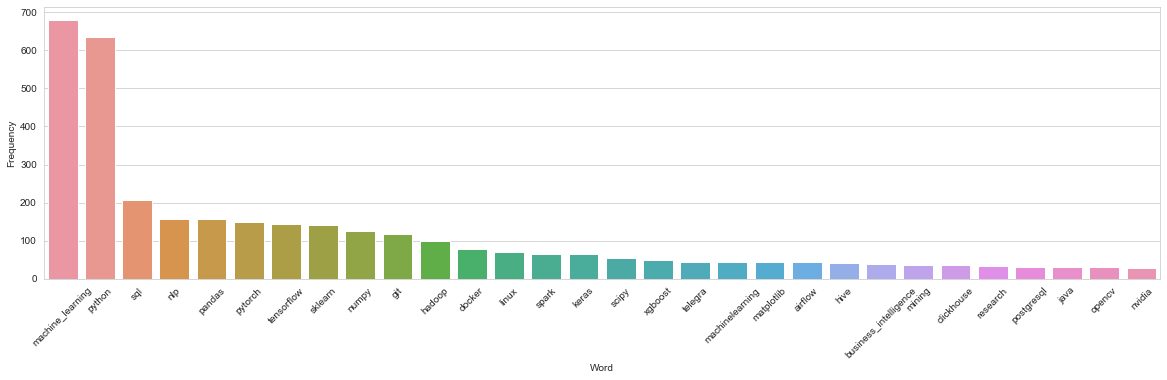

In [124]:
a_ds = (ds_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        #.replace('ml', 'machine_learning')
        #.replace('machine', 'machine_learning')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_ds = re.sub('[^A-Za-z]+', ' ', a_ds)

# список слов, которые не определяют навыки кандидата на вакансию
stop_words = ['https', 'proglib', 'with', 'fulltime', 'engineer', 'remote', 'middle', 'data', 
              'and', 'senior', 'the', 'for', 'com', 'science', 'our', 'scientist', 'vacancy', 'vacancies',  
              'junior', 'analytics', 'you', 'job', 'skills', 'time', 'work', 'etc', 'company',
             'tinkoff', 'experience', 'developer', 'dataengineer', 'knowledge', 'analyst', 'team',
             'business', 'product', 'lead', 'devops', 'full', 'gross', 'are', 'working', 'learning',
             'development', 'strong', 'from', 'will', 'computer', 'learn', 'analysis', 'to', 'of', 'in', 
              'ru', 'it', 'on', 'or', 'is', 'we', 'as', 'hr', 'be', 'cv', 'ds', 'platform', 'engineering',
             'at', 'hh', 'have', 'www', 'solutions', 'geekjob', 'intermediate', 'server', 'requirements', 
              'office', 'years', 'group', 'management', 'that', 'an', 'services', 'code', 'datascience',
             'web', 'vision', 'dl', 'new', 'software', 'telegram', 'scientists', 'big', 'io', 'net',
             'ms', 'cd', 'cpp', 'quality', 'open', 'world', 'using', 'google', 'yandex', 'cloud',
             'end', 'datascientist', 'streaming', 'qa', 'mobile', 'me', 'digital', 'sense', 'tg', 'processing',
             'tech', 'ad', 'salary', 'technologies', 'looking', 'your', 'ai', 'microsoft', 'deep', 'core', 'hoc',
             'system', 'join', 'one', 'machine', 'mail', 'technical', 'other', 'responsibilities', 'systems',
             'develop', 'models', 'tools', 'by', 'plus', 'ph', 'relocation', 'all', 'telega', 'teams',
             'offer'] #LAST_19_5_12_38


word_tokens_ds = word_tokenize(b_ds)

sentence = []
for w in word_tokens_ds:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_ds = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_ds = [word for word in without_single_chr_ds if not word.isnumeric()]        

# Посчитаем слова
words_ds = nltk.FreqDist(cleaned_data_ds)
rslt_ds = (
    pd.DataFrame(list(words_ds.items()), columns=['Word', 'Frequency'])
    .sort_values(by='Frequency', ascending=False)
    .query('Frequency > 3')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')


plt.figure(figsize=(20,5))
plt.xticks(rotation = 45)
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt_ds.head(30))

In [125]:
#wc(cleaned_data_title,'black','Frequent Words') 

In [126]:
# looker = teleg[teleg['text'].str.contains('amason')].reset_index()
# looker.head(2)

In [127]:
# определяем тип навыка - добавим столбцы, для того, чтобы определить к какой компетенции относится навык 
# куда правильно отнести airflow и nifi?

various_tasks = r'python|pandas|numpy|scipy|sql|git|google|api|excel'
vizualization = r'tableau|power_bi|seaborn|matplotlib|powerbi|matplotlib|grafana'
bi_tool = r'bi|qlik|powerbi|olap|sas'
cloud_computaring = r'aws|azure|bigquery|cloud'
stream_processing = r'hadoop|scala|hive|kafka|apache|spark|impala|flink'
database = r'etl|oracle|sap|greenplum|sql|postgresql|postgres|nosql|mysql|dwh|clickhouse|vertica|sap|mongodb|hbase|ssas|ssis '
etl_elt_tools = r'etl|elt|nifi|airflow'
maching_learning = r'machine_learning|tensorflow|pytorch|nlp|sklearn|ai|sklearn|scikit|keras'
software = r'docker|kubernetes|jira|sap|confluence'
operation_system = r'linux|android|ios|bash'
programming_lang = r'python|go|java|ci|kotlin|js'
other = r'mapreduce|xgboost|agile|gitlab|design|crm|rest|english'

#LAST_17_5_12_32

rslt_ds['position_name'] = 'ds'

rslt_ds['various_tasks'] = rslt_ds['Word'].apply(lambda x: True if re.search(various_tasks, x.lower()) else False)
rslt_ds['vizualization'] = rslt_ds['Word'].apply(lambda x: True if re.search(vizualization, x.lower()) else False)
rslt_ds['bi_tool'] = rslt_ds['Word'].apply(lambda x: True if re.search(bi_tool, x.lower()) else False)
rslt_ds['cloud_computaring'] = rslt_ds['Word'].apply(lambda x: True if re.search(cloud_computaring, x.lower()) else False)
rslt_ds['stream_processing'] = rslt_ds['Word'].apply(lambda x: True if re.search(stream_processing, x.lower()) else False)
rslt_ds['database'] = rslt_ds['Word'].apply(lambda x: True if re.search(database, x.lower()) else False)
rslt_ds['etl_elt_tools'] = rslt_ds['Word'].apply(lambda x: True if re.search(etl_elt_tools, x.lower()) else False)
rslt_ds['maching_learning'] = rslt_ds['Word'].apply(lambda x: True if re.search(maching_learning, x.lower()) else False)
rslt_ds['software'] = rslt_ds['Word'].apply(lambda x: True if re.search(software, x.lower()) else False)
rslt_ds['operation_system'] = rslt_ds['Word'].apply(lambda x: True if re.search(operation_system, x.lower()) else False)
rslt_ds['programming_lang'] = rslt_ds['Word'].apply(lambda x: True if re.search(programming_lang, x.lower()) else False)
rslt_ds['other'] = rslt_ds['Word'].apply(lambda x: True if re.search(other, x.lower()) else False)

rslt_ds = rslt_ds.head(60)
rslt_ds
#LAST_17_5_11_21

,Word,Frequency,position_name,various_tasks,vizualization,bi_tool,cloud_computaring,stream_processing,database,etl_elt_tools,maching_learning,software,operation_system,programming_lang,other
43,machine_learning,680,ds,False,False,False,False,False,False,False,True,False,False,False,False
47,python,636,ds,True,False,False,False,False,False,False,False,False,False,True,False
56,sql,208,ds,True,False,False,False,False,True,False,False,False,False,False,False
44,nlp,158,ds,False,False,False,False,False,False,False,True,False,False,False,False
48,pandas,158,ds,True,False,False,False,False,False,False,False,False,False,False,False
241,pytorch,148,ds,False,False,False,False,False,False,False,True,False,False,False,False
239,tensorflow,145,ds,False,False,False,False,False,False,False,True,False,False,False,False
50,sklearn,141,ds,False,False,False,False,False,False,False,True,False,False,False,False
49,numpy,126,ds,True,False,False,False,False,False,False,False,False,False,False,False
413,git,117,ds,True,False,False,False,False,False,False,False,False,False,False,False


In [128]:
ds_jun_vac = teleg.query('position_name == "ds" and grade == "Junior" ')

a_ds_jun = (ds_jun_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_ds_jun = re.sub('[^A-Za-z]+', ' ', a_ds_jun)

word_tokens_ds_jun = word_tokenize(b_ds_jun)

sentence = []
for w in word_tokens_ds_jun:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_ds_jun = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_ds_jun = [word for word in without_single_chr_ds_jun if not word.isnumeric()]        

# Посчитаем слова
words_ds_jun = nltk.FreqDist(cleaned_data_ds_jun)
rslt_ds_jun = (
    pd.DataFrame(list(words_ds_jun.items()), columns=['Word', 'Frequency_junior'])
    .sort_values(by='Frequency_junior', ascending=False)
    .query('Frequency_junior > 3')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_ds_jun['Junior'] = 'Junior'
rslt_ds_jun

,Word,Frequency_junior,Junior
82,conference,12,Junior
71,usa,8,Junior
3,machine_learning,8,Junior
66,summit,8,Junior
9,python,8,Junior
94,org,6,Junior
55,international,5,Junior
43,newhr,4,Junior
104,may,4,Junior


In [129]:
ds_jun_plus_vac = teleg.query('position_name == "ds" and grade == "Junior_plus" ')

a_ds_jun_plus = (ds_jun_plus_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_ds_jun_plus = re.sub('[^A-Za-z]+', ' ', a_ds_jun_plus)

word_tokens_ds_jun_plus = word_tokenize(b_ds_jun_plus)

sentence = []
for w in word_tokens_ds_jun_plus:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_ds_jun_plus = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_ds_jun_plus = [word for word in without_single_chr_ds_jun_plus if not word.isnumeric()]        

# Посчитаем слова
words_ds_jun_plus = nltk.FreqDist(cleaned_data_ds_jun_plus)
rslt_ds_jun_plus = (
    pd.DataFrame(list(words_ds_jun_plus.items()), columns=['Word', 'Frequency_junior_plus'])
    .sort_values(by='Frequency_junior_plus', ascending=False)
    .query('Frequency_junior_plus > 4')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_ds_jun_plus['Junior_plus'] = 'Junior_plus'
rslt_ds_jun_plus = rslt_ds_jun_plus.query('Frequency_junior_plus >= 7')
rslt_ds_jun_plus


,Word,Frequency_junior_plus,Junior_plus
25,python,68,Junior_plus
21,machine_learning,59,Junior_plus
62,sql,23,Junior_plus
71,git,22,Junior_plus
121,nvidia,20,Junior_plus
46,pandas,18,Junior_plus
38,tensorflow,18,Junior_plus
54,sklearn,16,Junior_plus
37,pytorch,16,Junior_plus
47,numpy,12,Junior_plus


In [130]:
ds_mid_vac = teleg.query('position_name == "ds" and grade == "Middle" ')

a_ds_mid = (ds_mid_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_ds_mid = re.sub('[^A-Za-z]+', ' ', a_ds_mid)

word_tokens_ds_mid = word_tokenize(b_ds_mid)

sentence = []
for w in word_tokens_ds_mid:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_ds_mid = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_ds_mid = [word for word in without_single_chr_ds_mid if not word.isnumeric()]        

# Посчитаем слова
words_ds_mid = nltk.FreqDist(cleaned_data_ds_mid)
rslt_ds_mid = (
    pd.DataFrame(list(words_ds_mid.items()), columns=['Word', 'Frequency_middle'])
    .sort_values(by='Frequency_middle', ascending=False)
    .query('Frequency_middle > 4')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_ds_mid['Middle'] = 'Middle'
rslt_ds_mid

,Word,Frequency_middle,Middle
15,python,40,Middle
4,machine_learning,31,Middle
17,git,17,Middle
16,sql,16,Middle
41,nlp,12,Middle
19,hadoop,10,Middle
196,business_intelligence,10,Middle
12,pytorch,10,Middle
21,hive,9,Middle
18,linux,8,Middle


In [131]:
ds_mid_plus_vac = teleg.query('position_name == "ds" and grade == "Middle_plus" ')

a_ds_mid_plus = (ds_mid_plus_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_ds_mid_plus = re.sub('[^A-Za-z]+', ' ', a_ds_mid_plus)

word_tokens_ds_mid_plus = word_tokenize(b_ds_mid_plus)

sentence = []
for w in word_tokens_ds_mid_plus:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_ds_mid_plus = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_ds_mid_plus = [word for word in without_single_chr_ds_mid_plus if not word.isnumeric()]        

# Посчитаем слова
words_ds_mid_plus = nltk.FreqDist(cleaned_data_ds_mid_plus)
rslt_ds_mid_plus = (
    pd.DataFrame(list(words_ds_mid_plus.items()), columns=['Word', 'Frequency_middle_plus'])
    .sort_values(by='Frequency_middle_plus', ascending=False)
    .query('Frequency_middle_plus > 5')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_ds_mid_plus['Middle_plus'] = 'Middle_plus'
rslt_ds_mid_plus = rslt_ds_mid_plus.query('Frequency_middle_plus >= 9')
rslt_ds_mid_plus


,Word,Frequency_middle_plus,Middle_plus
14,python,71,Middle_plus
19,machine_learning,52,Middle_plus
89,sql,26,Middle_plus
71,docker,19,Middle_plus
57,pytorch,16,Middle_plus
27,pandas,16,Middle_plus
70,git,15,Middle_plus
38,nlp,15,Middle_plus
84,tensorflow,14,Middle_plus
60,sklearn,12,Middle_plus


In [132]:
ds_senior_vac = teleg.query('position_name == "ds" and grade == "Senior" ')

a_ds_senior = (ds_senior_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_ds_senior = re.sub('[^A-Za-z]+', ' ', a_ds_senior)

word_tokens_ds_senior = word_tokenize(b_ds_senior)

sentence = []
for w in word_tokens_ds_senior:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_ds_senior = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_ds_senior = [word for word in without_single_chr_ds_senior if not word.isnumeric()]        

# Посчитаем слова
words_ds_senior = nltk.FreqDist(cleaned_data_ds_senior)
rslt_ds_senior = (
    pd.DataFrame(list(words_ds_senior.items()), columns=['Word', 'Frequency_senior'])
    .sort_values(by='Frequency_senior', ascending=False)
    .query('Frequency_senior > 4')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_ds_senior['Senior'] = 'Senior'
rslt_ds_senior = rslt_ds_senior.query('Frequency_senior >= 9')
rslt_ds_senior

,Word,Frequency_senior,Senior
99,machine_learning,151,Senior
10,python,135,Senior
20,sql,35,Senior
133,pytorch,26,Senior
14,pandas,26,Senior
17,tensorflow,26,Senior
170,nlp,24,Senior
15,numpy,23,Senior
179,hadoop,18,Senior
12,sklearn,18,Senior


In [133]:
ds_lead_vac = teleg.query('position_name == "ds" and grade == "Lead" ')

a_ds_lead = (ds_lead_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        .replace('machinelearning', 'machine_learning')    
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_ds_lead = re.sub('[^A-Za-z]+', ' ', a_ds_lead)

word_tokens_ds_lead = word_tokenize(b_ds_lead)

sentence = []
for w in word_tokens_ds_lead:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_ds_lead = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_ds_lead = [word for word in without_single_chr_ds_lead if not word.isnumeric()]        

# Посчитаем слова
words_ds_lead = nltk.FreqDist(cleaned_data_ds_lead)
rslt_ds_lead = (
    pd.DataFrame(list(words_ds_lead.items()), columns=['Word', 'Frequency_lead'])
    .sort_values(by='Frequency_lead', ascending=False)
    .query('Frequency_lead > 5')
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machinelearning', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun.head(30))

rslt_ds_lead['Lead'] = 'Lead'
rslt_ds_lead = rslt_ds_lead.query('Frequency_lead >= 8')
rslt_ds_lead

,Word,Frequency_lead,Lead
14,machine_learning,41,Lead
4,python,20,Lead
3,head,13,Lead
44,pandas,11,Lead
43,numpy,11,Lead
49,sklearn,10,Lead
45,scipy,9,Lead
178,analytical,9,Lead
46,clickhouse,9,Lead
175,sas,8,Lead


In [134]:
ds_nograde_vac = teleg.query('position_name == "ds" and grade == "Не указан" ')

a_ds_nograde = (ds_nograde_vac['text'].str.lower().str.cat(sep=' ')
        .replace('hdfs', 'hadoop')
        .replace('power', 'powerbi')
        .replace('powerbibi', 'powerbi')
        .replace('deep', 'deep_learning')
        .replace('scikit', 'sklearn')
        #.replace('bi', 'business_intelligence')
        #.replace('elt ', 'etl_elt')
        #.replace('elt', 'etl_elt')
       )

# удалим пунктуацию
b_ds_nograde = re.sub('[^A-Za-z]+', ' ', a_ds_nograde)

word_tokens_ds_nograde = word_tokenize(b_ds_nograde)

sentence = []
for w in word_tokens_ds_nograde:
    if w not in stop_words:
        sentence.append(w)

# очистим от слов, которые состоят из менее 2 символов
without_single_chr_ds_nograde = [word for word in sentence if len(word) > 1]

# очистим от чисел
cleaned_data_ds_nograde = [word for word in without_single_chr_ds_nograde if not word.isnumeric()]        

# Посчитаем слова
words_ds_nograde = nltk.FreqDist(cleaned_data_ds_nograde)
rslt_ds_nograde = (
    pd.DataFrame(list(words_ds_nograde.items()), columns=['Word', 'Frequency_nograde'])
    .sort_values(by='Frequency_nograde', ascending=False)
    .query('Frequency_nograde > 6').reset_index()
).replace('bi', 'business_intelligence').replace('ml', 'machine_learning')
#.replace('machine', 'machine_learning')

# plt.figure(figsize=(20,5))
# plt.xticks(rotation = 45)
# sns.set_style("whitegrid")
# ax = sns.barplot(x="Word",y="Frequency", data=rslt_de_jun_plus.head(30))

rslt_ds_nograde['no_grade'] = 'Не указан'
rslt_ds_nograde.head(40)

,index,Word,Frequency_nograde,no_grade
0,37,machine_learning,315,Не указан
1,41,python,285,Не указан
2,50,sql,96,Не указан
3,44,sklearn,78,Не указан
4,38,nlp,76,Не указан
5,42,pandas,75,Не указан
6,191,tensorflow,73,Не указан
7,193,pytorch,72,Не указан
8,43,numpy,59,Не указан
9,177,hadoop,48,Не указан


In [135]:
rslt_ds_total = rslt_ds_jun.merge(rslt_ds_jun_plus, on='Word', how='outer').fillna(0)
rslt_ds_total = rslt_ds_total.merge(rslt_ds_mid, on='Word', how='outer').fillna(0)
rslt_ds_total = rslt_ds_total.merge(rslt_ds_mid_plus, on='Word', how='outer').fillna(0)
rslt_ds_total = rslt_ds_total.merge(rslt_ds_senior, on='Word', how='outer').fillna(0)
rslt_ds_total = rslt_ds_total.merge(rslt_ds_lead, on='Word', how='outer').fillna(0)
rslt_ds_total = rslt_ds_total.merge(rslt_ds_nograde, on='Word', how='outer').fillna(0)

rslt_ds_total['Frequency_junior'] = rslt_ds_total['Frequency_junior'].astype('int')
rslt_ds_total['Frequency_junior_plus'] = rslt_ds_total['Frequency_junior_plus'].astype('int')
rslt_ds_total['Frequency_middle'] = rslt_ds_total['Frequency_middle'].astype('int')
rslt_ds_total['Frequency_middle_plus'] = rslt_ds_total['Frequency_middle_plus'].astype('int')
rslt_ds_total['Frequency_senior'] = rslt_ds_total['Frequency_senior'].astype('int')
rslt_ds_total['Frequency_lead'] = rslt_ds_total['Frequency_lead'].astype('int')
rslt_ds_total['Frequency_nograde'] = rslt_ds_total['Frequency_nograde'].astype('int')

rslt_ds_total['Frequency_total'] = (
    rslt_ds_total['Frequency_junior'] + rslt_ds_total['Frequency_junior_plus']
    + rslt_ds_total['Frequency_middle'] + rslt_ds_total['Frequency_middle_plus']
     + rslt_ds_total['Frequency_senior'] + rslt_ds_total['Frequency_lead'] + rslt_ds_total['Frequency_nograde']
)

rslt_ds_total = rslt_ds_total.drop(['index'],axis=1).reset_index(drop=True)
rslt_ds_total  = rslt_ds_total.query('Frequency_total >= 10')

rslt_ds_total['position_name'] = 'ds'
rslt_ds_total.sort_values(by='Frequency_total', ascending=False).head(40)

,Word,Frequency_junior,Junior,Frequency_junior_plus,Junior_plus,Frequency_middle,Middle,Frequency_middle_plus,Middle_plus,Frequency_senior,Senior,Frequency_lead,Lead,Frequency_nograde,no_grade,Frequency_total,position_name
2,machine_learning,8,Junior,59,Junior_plus,31,Middle,52,Middle_plus,151,Senior,41,Lead,315,Не указан,657,ds
4,python,8,Junior,68,Junior_plus,40,Middle,71,Middle_plus,135,Senior,20,Lead,285,Не указан,627,ds
9,sql,0,0,23,Junior_plus,16,Middle,26,Middle_plus,35,Senior,0,0,96,Не указан,196,ds
12,pandas,0,0,18,Junior_plus,5,Middle,16,Middle_plus,26,Senior,11,Lead,75,Не указан,151,ds
15,pytorch,0,0,16,Junior_plus,10,Middle,16,Middle_plus,26,Senior,0,0,72,Не указан,140,ds
13,tensorflow,0,0,18,Junior_plus,5,Middle,14,Middle_plus,26,Senior,0,0,73,Не указан,136,ds
22,nlp,0,0,8,Junior_plus,12,Middle,15,Middle_plus,24,Senior,0,0,76,Не указан,135,ds
14,sklearn,0,0,16,Junior_plus,0,0,12,Middle_plus,18,Senior,10,Lead,78,Не указан,134,ds
16,numpy,0,0,12,Junior_plus,0,0,10,Middle_plus,23,Senior,11,Lead,59,Не указан,115,ds
10,git,0,0,22,Junior_plus,17,Middle,15,Middle_plus,11,Senior,0,0,43,Не указан,108,ds


In [136]:
world_list_all = pd.concat([rslt_de_total, rslt_da_total, rslt_ds_total])
world_list_all.head(2)

,Word,Frequency_junior,Junior,Frequency_junior_plus,Junior_plus,Frequency_middle,Middle,Frequency_middle_plus,Middle_plus,Frequency_senior,Senior,Frequency_lead,Lead,index,Frequency_nograde,no_grade,Frequency_total,position_name
0,hadoop,28,Junior,67,Junior_plus,31,Middle,60,Middle_plus,59,Senior,29,Lead,9.0,250,Не указан,524,de
1,linux,13,Junior,17,Junior_plus,6,Middle,14,Middle_plus,11,Senior,0,0,263.0,55,Не указан,116,de


In [137]:
#world_list_all_13_6 = world_list_all.to_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Пасека\Парсер вакансий в Телеграм\final_one\world_list_all_13_6.csv')

In [138]:
skills_list_20_6 = world_list_all.to_csv(r'C:\Users\mirra\Desktop\Yandex.praktikum\Пасека\Парсер вакансий в Телеграм\final_one\skills_list_20_6.csv')